# 02/09/24 - Results from scripts today, 5 models, only PL.
# 02/08/24 - Results from my scripts today.
# 02/07/24 - Added spherical modeling and OM anisotropy
# 02/02/24 - Modified so that I can show the differences between cyl/sph and MFL/PL
# 02/01/24 - This notebook was copied from 011924_jam_mass_profile_testing.ipynb and will be used to measure the enclossed mass within the einstein radius of mass-follows-light models
______________
# 01/19/24 - This notebook tests my mass profile class "total_mass_mge" in e.g.
# 01/29/24 - Added looking at the mass profile and brightness profile at Michele's suggestion, using the mass-follows-light to compare with powerlaw
# 01/30/24 - Added Michele's power law code to see if I can reproduce it.
## Shawn wrote this. I've compiled this to be ready for Michele to test.

In [1]:
# import general libraries and modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['mathtext.fontset'] = 'dejavuserif'
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams.update({'font.size': 16})
%matplotlib inline
import pandas as pd
import dill as pickle
from glob import glob

# astronomy/scipy
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
import astropy.units as u
import astropy.constants as constants

# ppxf/capfit
from ppxf.capfit import capfit

# mge fit
import mgefit
from mgefit.mge_fit_1d import mge_fit_1d

# jampy
from jampy.jam_axi_proj import jam_axi_proj
from jampy.jam_sph_proj import jam_sph_proj
from jampy.mge_half_light_isophote import mge_half_light_isophote
from jampy.mge_half_light_isophote import mge_half_light_radius

# plotbin
from plotbin.plot_velfield import plot_velfield
from plotbin.symmetrize_velfield import symmetrize_velfield
from plotbin.sauron_colormap import register_sauron_colormap
register_sauron_colormap()


# my functions
import sys
sys.path.append("/home/shawnknabel/Documents/slacs_kinematics/my_python_packages")
import slacs_mge_jampy

################################################################
# some needed information
kcwi_scale = 0.1457  # arcsec/pixel

# value of c^2 / 4 pi G
c2_4piG = (constants.c **2 / constants.G / 4 / np.pi).to('solMass/pc')


In [2]:
#################################################
# objects
obj_names = ['SDSSJ0029-0055', 
             'SDSSJ0037-0942',
             'SDSSJ0330-0020',
             'SDSSJ1112+0826',
             'SDSSJ1204+0358',
             'SDSSJ1250+0523',
             'SDSSJ1306+0600',
             'SDSSJ1402+6321',
             'SDSSJ1531-0105',
             'SDSSJ1538+5817',
             'SDSSJ1621+3931',
             'SDSSJ1627-0053',
             'SDSSJ1630+4520',
             'SDSSJ2303+1422'
            ]

In [8]:
#################################################
# directories and tables

date_of_kin = '2023-02-28_2'
# data directory
data_dir = '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/'
hst_dir = '/data/raw_data/HST_SLACS_ACS/kcwi_kinematics_lenses/'
tables_dir = f'{data_dir}tables/'
mosaics_dir = f'{data_dir}mosaics/'
kinematics_full_dir = f'{data_dir}kinematics/'
kinematics_dir =f'{kinematics_full_dir}{date_of_kin}/'
jam_output_dir = f'{data_dir}jam_outputs/2024_02_09_jam_milestone_outputs/'
milestone_dir = f'{data_dir}milestone23_data/'

paper_table = pd.read_csv(f'{tables_dir}paper_table_100223.csv')
slacs_ix_table = pd.read_csv(f'{tables_dir}slacs_ix_table3.csv')
zs = paper_table['zlens']
zlenses = slacs_ix_table['z_lens']
zsources = slacs_ix_table['z_src']
# get the revised KCWI sigmapsf
sigmapsf_table = pd.read_csv(f'{tables_dir}kcwi_sigmapsf_estimates.csv')
lens_models = pd.read_csv(f'{tables_dir}lens_models_table_chinyi.csv')

In [9]:
lens_models_chinyi = pd.read_csv(f'{tables_dir}lens_models_table_chinyi.csv')
lens_models_chinyi_sys = pd.read_csv(f'{tables_dir}lens_models_table_chinyi_with_sys.csv')
lens_models_anowar = pd.read_csv(f'{tables_dir}lens_models_table_anowar.csv')

lens_models_chinyi_sys.rename(columns={'dgamma':'gamma_err',
                                       'dgamma_sys':'gamma_sys',
                                      },inplace=True)


lens_models_chinyi_sys['dgamma'] = np.sqrt( lens_models_chinyi_sys['gamma_err']**2 + lens_models_chinyi_sys['gamma_sys']**2 )
lens_models_chinyi_sys.loc[9, 'dgamma'] = np.sqrt( lens_models_chinyi_sys.loc[9, 'gamma_err']**2 + np.nanmean(lens_models_chinyi_sys['gamma_sys'])**2)
lens_models = lens_models_chinyi_sys

# Functions needed to get the data, etc

In [10]:
###############################################################################

# class to collect and save all the attributes I need for jampy
class jampy_details:
    
    def __init__(details, surf_density, mge_sigma, q, kcwi_sigmapsf, Vrms_bin, dVrms_bin, V_bin, dV_bin, xbin_phot, ybin_phot, reff):
        details.surf_density=surf_density 
        details.mge_sigma=mge_sigma
        details.q=q 
        details.kcwi_sigmapst=kcwi_sigmapsf 
        details.Vrms_bin=Vrms_bin 
        details.dVrms_bind=dVrms_bin
        details.V_bin=V_bin 
        details.dV_bin=dV_bin 
        details.xbin_phot=xbin_phot 
        details.ybin_phot=ybin_phot
        details.reff=reff
        
        
###############################################################################


def prepare_to_jam(obj_name, file_dir, SN):

    # take the surface density, etc from mge saved parameters
    with open(f'{file_dir}{obj_name}_{SN}_details_for_jampy.pkl', 'rb') as f:
        tommy_pickles = pickle.load(f)
        
    surf = tommy_pickles.surf_density
    sigma = tommy_pickles.mge_sigma
    qObs = tommy_pickles.q
    #kcwi_sigmapsf = tommy_pickles.kcwi_sigmapst # mistake in name  
    try:
        kcwi_sigmapsf = tommy_pickles.kcwi_sigmapsf
    except:
        kcwi_sigmapsf = tommy_pickles.kcwi_sigmapst
    Vrms_bin = tommy_pickles.Vrms_bin
    try:
        dVrms_bin = tommy_pickles.dVrms_bin 
    except:
        dVrms_bin = tommy_pickles.dVrms_bind # mistake in name
    V_bin = tommy_pickles.V_bin
    dV_bin = tommy_pickles.dV_bin
    xbin_phot = tommy_pickles.xbin_phot
    ybin_phot = tommy_pickles.ybin_phot
    reff = tommy_pickles.reff
    
    return (surf, sigma, qObs, kcwi_sigmapsf, Vrms_bin, dVrms_bin, V_bin, dV_bin, xbin_phot, ybin_phot, reff)

def calculate_1d_gaussian(r, amp, sigma):
    return amp * np.exp(-1/2 * r**2 / sigma**2)



# Michele's power law code

In [11]:
###############################################################################

def total_mass_mge_cap(gamma, rbreak):
    """
    Returns the MGE parameters for a generalized NFW dark halo profile
    https://ui.adsabs.harvard.edu/abs/2001ApJ...555..504W
    - gamma is the inner logarithmic slope (gamma = -1 for NFW)
    - rbreak is the break radius in arcsec

    """
    # The fit is performed in log spaced radii from 0.01" to 10*rbreak
    n = 1000#300     # Number of values to sample the gNFW profile for the MGE fit
    r = np.geomspace(0.01, rbreak, n)   # logarithmically spaced radii in arcsec
    rho = (r/rbreak)**gamma * (0.5 + 0.5*r/rbreak)**(-gamma - 3)  # rho=1 at r=rbreak
    ngauss=30#15
    m = mge_fit_1d(r, rho, ngauss=ngauss, inner_slope=2, outer_slope=3, quiet=1, plot=1)

    surf_dm, sigma_dm = m.sol           # Peak surface density and sigma
    #surf_dm /= np.sqrt(2*np.pi*sigma_dm**2)
    qobs_dm = np.ones_like(surf_dm)     # Assume spherical dark halo

    return surf_dm, sigma_dm, qobs_dm

###############################################################################

def jam_resid(pars, surf_lum=None, sigma_lum=None, qobs_lum=None, 
              distance=None, align=None, goodbins=None,
              xbin=None, ybin=None, sigmapsf=None, normpsf=None, 
              rms=None, erms=None, pixsize=None, plot=True, return_mge=False):

    q, ratio, gamma = pars

    # Sample inclination using min(q), with Equation (14) of Cappellari (2008)
    qmin = np.min(qobs_lum)
    inc = np.degrees(np.arctan2(np.sqrt(1 - qmin**2), np.sqrt(qmin**2 - q**2)))
    beta = np.full_like(qobs_lum, 1 - ratio**2)   # assume constant anisotropy

    rbreak = 50 # arcsec 20*reff
    mbh = 0                     # Ignore the central black hole
    surf_pot, sigma_pot, qobs_pot = total_mass_mge_cap(gamma, rbreak)

    jam = jam_axi_proj(surf_lum, sigma_lum, qobs_lum, surf_pot, sigma_pot, qobs_pot,
                       inc, mbh, distance, xbin, ybin, plot=plot, pixsize=pixsize, quiet=1,
                       sigmapsf=sigmapsf, normpsf=normpsf, goodbins=goodbins, align=align,
                       beta=beta, data=rms, errors=erms, ml=None)
    resid = (rms[goodbins] - jam.model[goodbins])/erms[goodbins]
    chi2 = np.sum(resid**2)
    
    if return_mge==True:
        
        # return the mass mge multiplied by the ml from jam
        return surf_pot*jam.ml, sigma_pot, qobs_pot, chi2
    
    else:
        return resid   # ln(likelihood) + cost.



In [12]:
def calculate_mass_and_slope_enclosed(surf_pot, sigma_pot, qobs_pot, distance, radius, plot=False):
    
    # circularize mass
    pc = distance*np.pi/0.648 # constant factor arcsec -> pc
    sigma = sigma_pot*np.sqrt(qobs_pot) # circularize while conserving mass
    mass = 2*np.pi*surf_pot*(sigma*pc)**2 # keep peak surface brightnesss of each gaussian
    mass_tot = np.sum(mass)
    
    # radii to sample
    nrad = 50
    rmin = 0.01 #np.min(sigma)
    rad = np.geomspace(rmin, radius, nrad) # arcsec
    
    # enclosed mass is integral
    mass_enclosed = (mass*(1 - np.exp(-0.5*(rad[:, None]/sigma)**2))).sum(1)[-1]
    
    # slope is average over interval
    mass_profile_1d = np.zeros_like(rad, dtype=float)
    for i in range(len(surf_pot)):
        amp = surf_pot[i]
        sigma = sigma_pot[i]
        q = qobs_pot[i]
        zz = calculate_1d_gaussian(rad, amp, sigma)
        mass_profile_1d += zz
    # diff in log space minus 1 (because we're in surface mass density    
    gamma_avg = (np.log(mass_profile_1d[-1])-np.log(mass_profile_1d[0]))/(np.log(rad[-1])-np.log(rad[0]))-1
    
    # add up the mass profile
    r = np.geomspace(np.min(sigma_pot), np.max(sigma_pot), nrad) # arcsec
    # slope is average over interval
    mass_profile_1d = np.zeros_like(r, dtype=float)
    for i in range(len(surf_pot)):
        amp = surf_pot[i]
        sigma = sigma_pot[i]
        q = qobs_pot[i]
        zz = calculate_1d_gaussian(r, amp, sigma)
        mass_profile_1d += zz
        
    if plot==True:
        plt.loglog(r, mass_profile_1d)
        plt.pause(1)
        
    return mass_enclosed, gamma_avg, r, mass_profile_1d


# Get the different combinations of things
## PL, MFL, Const, OM, axicyl, axisph, sphsph

In [40]:
# mass model
pl = glob(f'{jam_output_dir}*pl*.txt')
pl_sol = glob(f'{jam_output_dir}*pl*sol*.txt')
mfl = glob(f'{jam_output_dir}*mfl*.txt')
mfl_sol = glob(f'{jam_output_dir}*mfl*sol*.txt')
# anisotropy
const = glob(f'{jam_output_dir}*const*.txt')
const_sol = glob(f'{jam_output_dir}*const*sol*.txt')
om = glob(f'{jam_output_dir}*om*.txt')
om_sol = glob(f'{jam_output_dir}*om*sol*.txt')
# geometry
axicyl = glob(f'{jam_output_dir}*axicyl*.txt')
axicyl_sol = glob(f'{jam_output_dir}*axicyl*sol*.txt')
axisph = glob(f'{jam_output_dir}*axisph*.txt')
axisph_sol = glob(f'{jam_output_dir}*axisph*sol*.txt')
sphsph = glob(f'{jam_output_dir}*sphsph*.txt')
sphsph_sol = glob(f'{jam_output_dir}*sphsph*sol*.txt')


# Start with power law slope

In [41]:
pl_sol

['/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/2024_02_09_jam_milestone_outputs/jam_pl_om_sphsph_solutions_2024_02_09.txt',
 '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/2024_02_09_jam_milestone_outputs/jam_pl_const_axisph_solutions_2024_02_09.txt',
 '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/2024_02_09_jam_milestone_outputs/jam_pl_const_sphsph_solutions_2024_02_09.txt',
 '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/2024_02_09_jam_milestone_outputs/jam_pl_const_axicyl_solutions_2024_02_09.txt',
 '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/2024_02_09_jam_milestone_outputs/jam_pl_om_axisph_solutions_2024_02_09.txt']

In [42]:
pl_sol.sort()

In [43]:
pl_sol

['/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/2024_02_09_jam_milestone_outputs/jam_pl_const_axicyl_solutions_2024_02_09.txt',
 '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/2024_02_09_jam_milestone_outputs/jam_pl_const_axisph_solutions_2024_02_09.txt',
 '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/2024_02_09_jam_milestone_outputs/jam_pl_const_sphsph_solutions_2024_02_09.txt',
 '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/2024_02_09_jam_milestone_outputs/jam_pl_om_axisph_solutions_2024_02_09.txt',
 '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/2024_02_09_jam_milestone_outputs/jam_pl_om_sphsph_solutions_2024_02_09.txt']

In [44]:
gammas = np.empty((5, 14))
gamma_errs = np.empty((5,14))
pl_labels = ['const axi cyl',
                'const axi sph',
                'const sph',
                'om axi sph',
                'om sph'
               ]

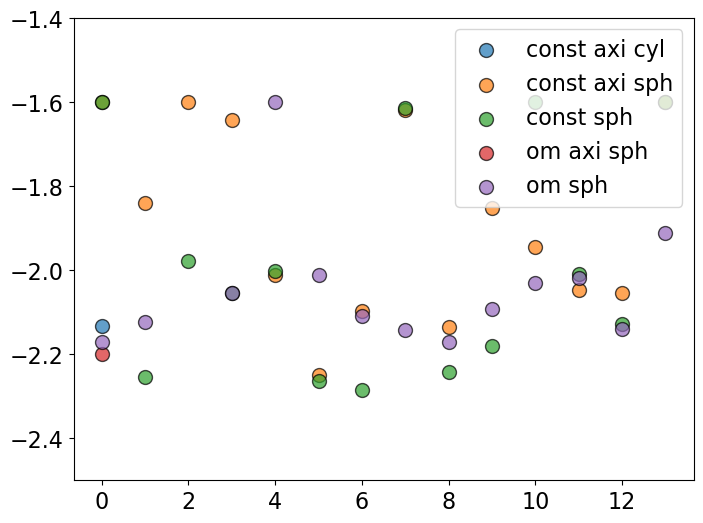

In [45]:
plt.figure(figsize=(8,6))

for i, file in enumerate(pl_sol):
    
    # get the solutions
    solutions = np.genfromtxt(file)
    
    
    # gamma and gamma_err are index 3 and 4
    gamma = solutions[:,3]
    gamma_err = solutions[:,4]
    
    gammas[i] = gamma
    gamma_errs[i] = gamma_err
    
    alpha=0.7
    # plot
    x = range(14)
    #plt.errorbar(x, gamma, yerr=gamma_err, label=file)
    plt.scatter(x, gamma, label=pl_labels[i], alpha=alpha, edgecolor='k', s=100)
    plt.legend()
    plt.ylim(-2.5, -1.4)
    

In [46]:
gammas

array([[-2.13302633,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ],
       [-1.6       , -1.84005905, -1.6       , -1.64221393, -2.01211111,
        -2.25015084, -2.09804772, -1.61804287, -2.13463338, -1.85177036,
        -1.94497761, -2.04599333, -2.05393356, -1.6       ],
       [-1.6       , -2.25428211, -1.97837743, -2.05516439, -2.00148325,
        -2.26369903, -2.28386663, -1.61347609, -2.24199599, -2.17919403,
        -1.6       , -2.00833979, -2.1287745 , -1.6       ],
       [-2.19926923,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ],
       [-2.1710288 , -2.12267271,  1.        , -2.05391513, -1.6       ,
        -2.01187806, -2.10892332, -2.14319199, -2.17185085, -2.09153787,
        -2.03065715, -2.01

## Bring in the lens models

In [33]:
lens_gammas = lens_models['gamma'] #np.delete(lens_models['gamma'], 2)
lens_gamma_errs = lens_models['dgamma'] #np.delete(lens_models['dgamma'], 2)

In [36]:
# Just remove 2 altogether

#gammas = np.delete(gammas, 2, axis=1)
#gamma_errs = np.delete(gamma_errs, 2, axis=1)

In [37]:
pl_colors = ['r','b','g','orange','purple']
pl_markers = ['o','>','s','D','^']

/tmp/ipykernel_16527/181580307.py:24: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(j, -gamma, label=label, alpha=alpha, color=pl_colors[i], edgecolor='k', s=100, marker=marker)


Text(0.5, 0, 'object')

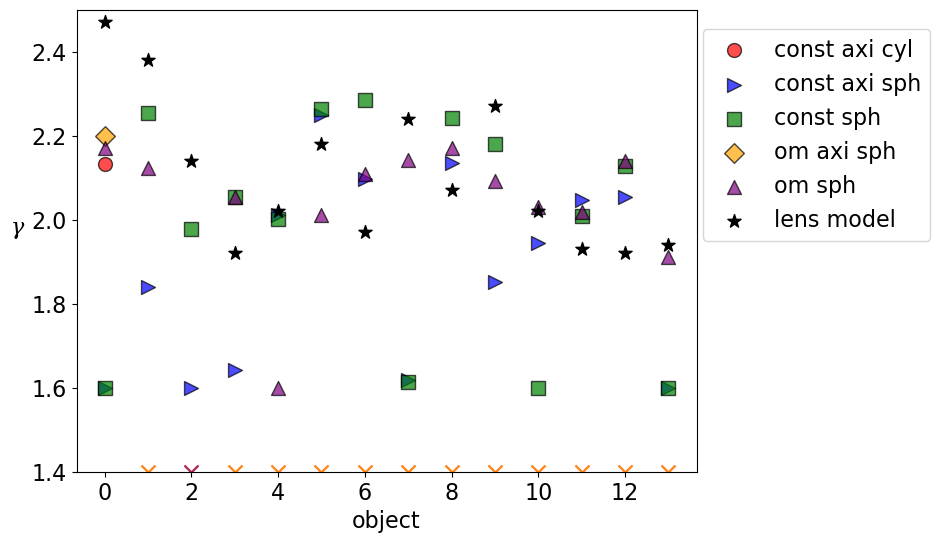

In [38]:
# plot them, but indicate where one of them was extremely bad

for i, model in enumerate(gammas):
    
    for j, gamma in enumerate(model):
        
        if gamma > -1.4:
            marker='x'
            gamma = -1.4
        elif gamma < -2.5:
            marker='x'
            gamma = -2.5
        else:
            marker=pl_markers[i]
        
        if j==0:
            label = pl_labels[i]
        else:
            label = None
            
        alpha=0.7
        # plot
        #plt.errorbar(x, gamma, yerr=gamma_err, label=file)
        plt.scatter(j, -gamma, label=label, alpha=alpha, color=pl_colors[i], edgecolor='k', s=100, marker=marker)
    
plt.scatter(range(14), lens_gammas, c='k', s=100, marker='*', label='lens model')
    
plt.legend(loc=(1.01,0.5))
plt.ylim(1.4, 2.5)
plt.ylabel(r'$\gamma$', rotation='horizontal', labelpad=10)
plt.xlabel('object')

In [23]:
gammas[:,2]

array([ 1.        , -1.6       , -1.97837743,  1.        ,  0.16690495])

Text(0.5, 0, 'object')

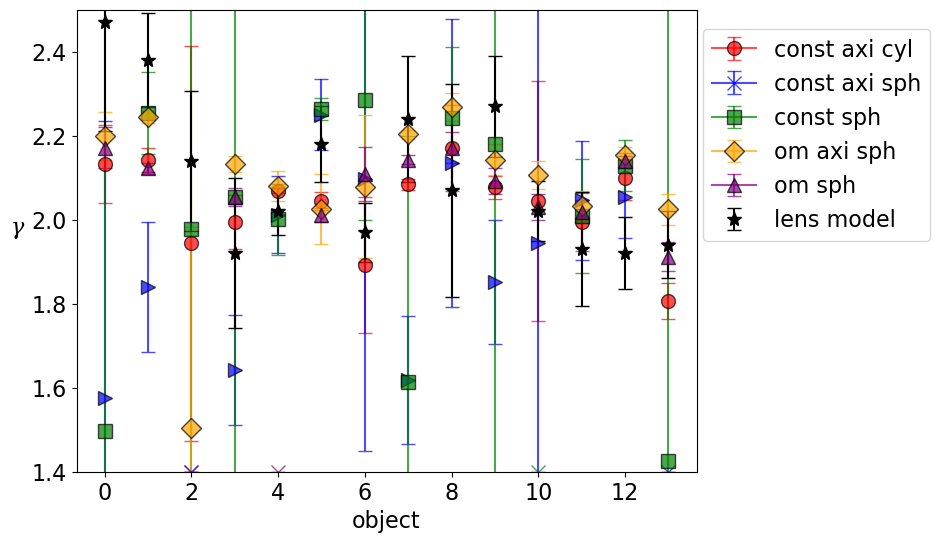

In [23]:
# plot them, but indicate where one of them was extremely bad

for i, model in enumerate(gammas):
    
    for j, gamma in enumerate(model):
        
        gamma_err = gamma_errs[i,j]
        if gamma > -1.4:
            marker='x'
            gamma = -1.4
            gamma_err = 0
            markeredgecolor=pl_colors[i]
        else:
            marker=pl_markers[i]
            markeredgecolor='k'
        
        if j==len(model)-1:
            label = pl_labels[i]
        else:
            label = None
            
        alpha=0.7
        # plot
        #plt.errorbar(x, gamma, yerr=gamma_err, label=file)
        plt.errorbar(j, -gamma, yerr=gamma_err, label=label, alpha=alpha, color=pl_colors[i], markerfacecolor=pl_colors[i], markeredgecolor=markeredgecolor, markersize=10, marker=marker, capsize=5)
    
plt.errorbar(range(14), lens_gammas, yerr=lens_gamma_errs, c='k', markersize=10, marker='*', ls='none', label='lens model', capsize=5)
    
plt.legend(loc=(1.01,0.5))
plt.ylim(1.4, 2.5)
plt.ylabel(r'$\gamma$', rotation='horizontal', labelpad=10)
plt.xlabel('object')

In [24]:
gamma_errs[:2]

array([[0.09215648, 0.02838206, 0.47031779, 0.06461047, 0.00609226,
        0.0210008 , 0.16264135, 0.01316311, 0.10210806, 0.02715939,
        0.28599383, 0.06903884, 0.05194858, 0.04285273],
       [0.65970201, 0.15566689, 0.93681522, 0.13178273, 0.09183353,
        0.08504057, 0.64915051, 0.15248346, 0.34295182, 0.14775907,
        0.96644512, 0.14125701, 0.09825882, 0.60645004]])

In [25]:
gammas[:2]

array([[-2.13302633, -2.14149972, -1.94447691, -1.99419008, -2.06907222,
        -2.04510158, -1.8920132 , -2.08410461, -2.17115775, -2.07708876,
        -2.04511909, -1.99419243, -2.09978624, -1.80683748],
       [-1.57546022, -1.84005905, -1.21062455, -1.64221393, -2.01211111,
        -2.25015084, -2.09804772, -1.61804287, -2.13463338, -1.85177036,
        -1.94497761, -2.04599333, -2.05393356, -1.12283675]])

# Look at anisotropy

In [26]:
anis = np.empty((5, 14))
ani_errs = np.empty((5,14))


/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/2024_02_07_jam_milestone_outputs/jam_pl_const_axicyl_solutions_02072024.txt
/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/2024_02_07_jam_milestone_outputs/jam_pl_const_axisph_solutions_02072024.txt
/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/2024_02_07_jam_milestone_outputs/jam_pl_const_sphsph_solutions_02072024.txt
/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/2024_02_07_jam_milestone_outputs/jam_pl_om_axisph_solutions_02072024.txt
/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/2024_02_07_jam_milestone_outputs/jam_pl_om_sphsph_solutions_02072024.txt


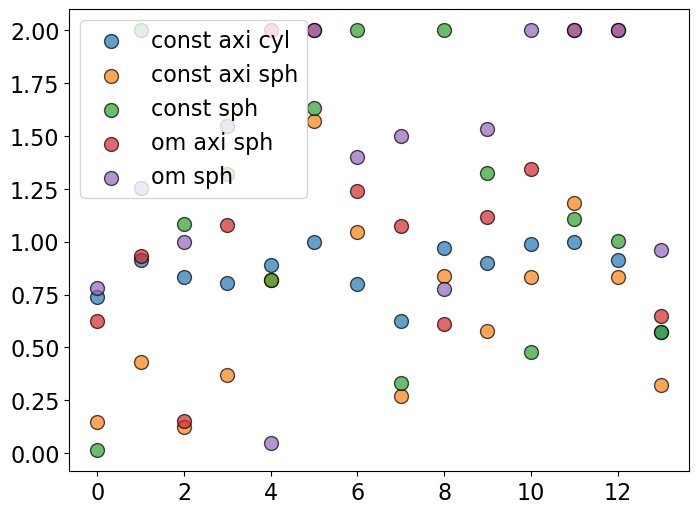

In [27]:
plt.figure(figsize=(8,6))

for i, file in enumerate(pl_sol):
    print(file)
    
    # get the solutions
    solutions = np.genfromtxt(file)
    
    
    # gamma and gamma_err are index 3 and 4
    ani = solutions[:,1]
    ani_err = solutions[:,2]
    
    anis[i] = ani
    ani_errs[i] = ani_err
    
    alpha=0.7
    # plot
    x = range(14)
    #plt.errorbar(x, gamma, yerr=gamma_err, label=file)
    plt.scatter(x, ani, label=pl_labels[i], alpha=alpha, edgecolor='k', s=100)
    plt.legend()
    #plt.ylim(-2.5, -1.4)

# Just remove 2 altogether

anis = np.delete(anis, 2, axis=1)
ani_errs = np.delete(ani_errs, 2, axis=1)

/tmp/ipykernel_16349/2174062431.py:28: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(j, beta, label=label, alpha=alpha, color=pl_colors[i], edgecolor='k', s=100, marker=marker)


(-0.85, 1.0)

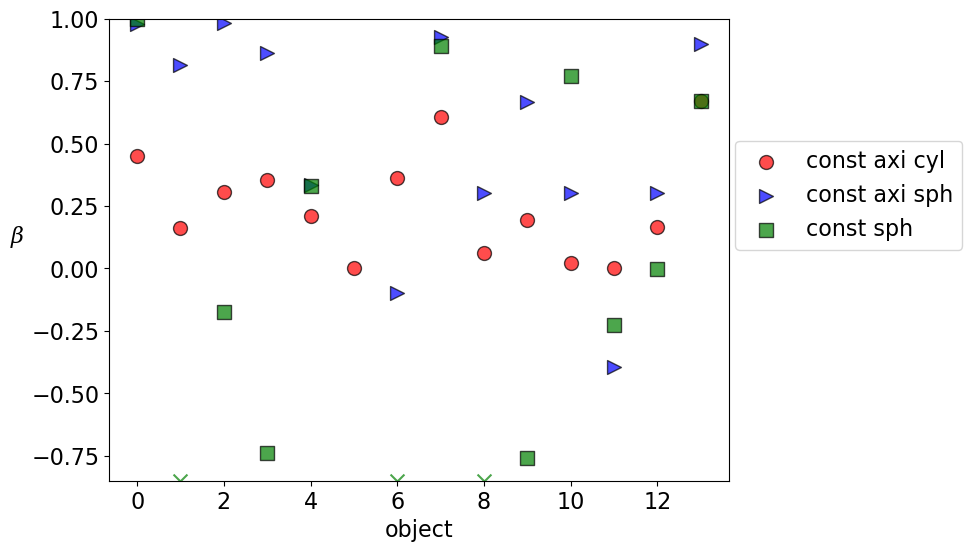

In [28]:
# Look at only constant anis

plt.figure(figsize=(8,6))

for i, model in enumerate(anis[:3]):
    
    for j, ani in enumerate(model):
        
        # take the beta value
        beta = 1-ani**2
        
        if beta==-3:
            marker='x'
            beta=-0.85
        elif beta==1:
            marker='x'
        else:
            marker=pl_markers[i]
        
        if j==len(model)-1:
            label = pl_labels[i]
        else:
            label = None
            
        alpha=0.7
        # plot
        #plt.errorbar(x, gamma, yerr=gamma_err, label=file)
        plt.scatter(j, beta, label=label, alpha=alpha, color=pl_colors[i], edgecolor='k', s=100, marker=marker)
        
plt.legend(loc=(1.01,0.5))
plt.ylabel(r'$\beta$', rotation='horizontal', labelpad=10)
plt.xlabel('object')
plt.ylim(-0.85, 1)

(-0.85, 1.0)

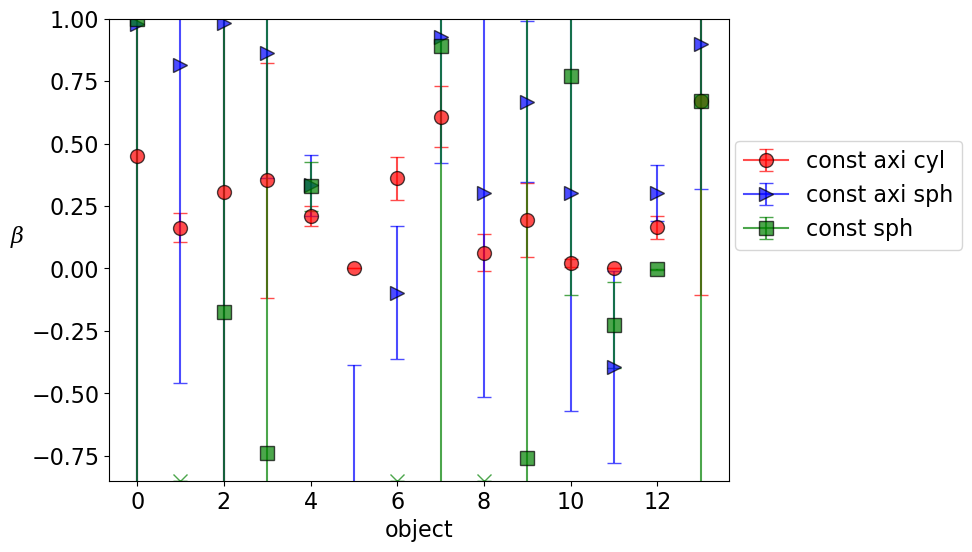

In [29]:
# Look at only constant anis

plt.figure(figsize=(8,6))

for i, model in enumerate(anis[:3]):
    
    for j, ani in enumerate(model):
        
        ani_err = ani_errs[i,j]
        
        # take the beta value
        beta = 1-ani**2
        beta_err = np.sqrt(np.square(2 * beta * ani_err / ani))
        
        if beta==-3:
            marker='x'
            beta=-0.85
            beta_err=0
            markeredgecolor=pl_colors[i]
        else:
            marker=pl_markers[i]
            markeredgecolor='k'
        
        if j==len(model)-1:
            label = pl_labels[i]
        else:
            label = None
            
        alpha=0.7
        # plot
        #plt.errorbar(x, gamma, yerr=gamma_err, label=file)
        plt.errorbar(j, beta, yerr=beta_err, label=label, alpha=alpha, color=pl_colors[i], markeredgecolor=markeredgecolor, markersize=10, marker=marker, capsize=5)
        
plt.legend(loc=(1.01,0.5))
plt.ylabel(r'$\beta$', rotation='horizontal', labelpad=10)
plt.xlabel('object')
plt.ylim(-0.85, 1)

Text(0.5, 0, 'object')

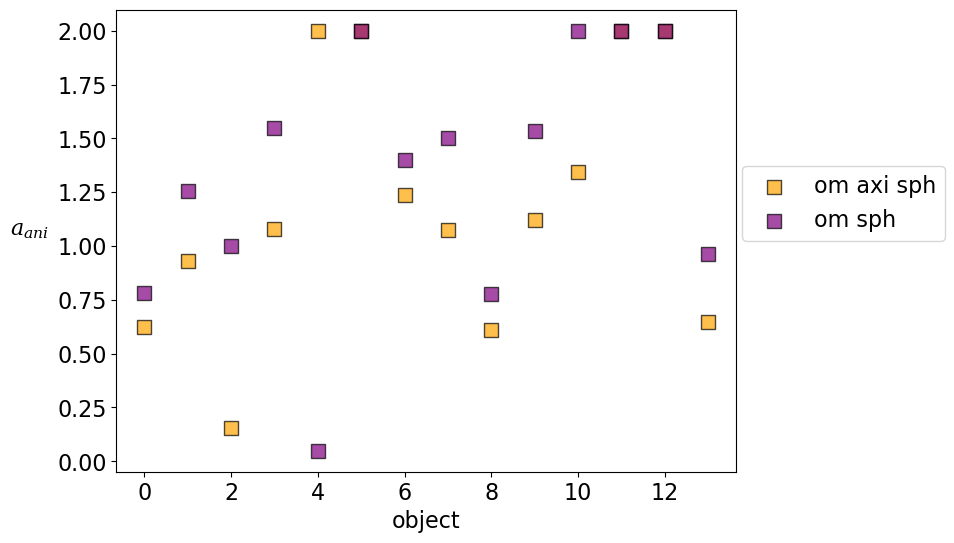

In [30]:
plt.figure(figsize=(8,6))

for i, model in enumerate(anis[3:]):
    
    for j, ani in enumerate(model):
        
        # take the beta value
        #beta = 1-ani**2
        
        #if beta==-3:
        #    marker='x'
        #    beta=-0.75
        #else:
        #    marker=pl_markers[i+3]
        
        if j==len(model)-1:
            label = pl_labels[i+3]
        else:
            label = None
            
        alpha=0.7
        # plot
        #plt.errorbar(x, gamma, yerr=gamma_err, label=file)
        plt.scatter(j, ani, label=label, alpha=alpha, color=pl_colors[i+3], edgecolor='k', s=100, marker=marker)
        
plt.legend(loc=(1.01,0.5))
#plt.ylim(-2.5, -1.4)
plt.ylabel(r'$a_{ani}$', rotation='horizontal', labelpad=20)
plt.xlabel('object')
#plt.ylim(-0.75, 1)

(0.0, 2.0)

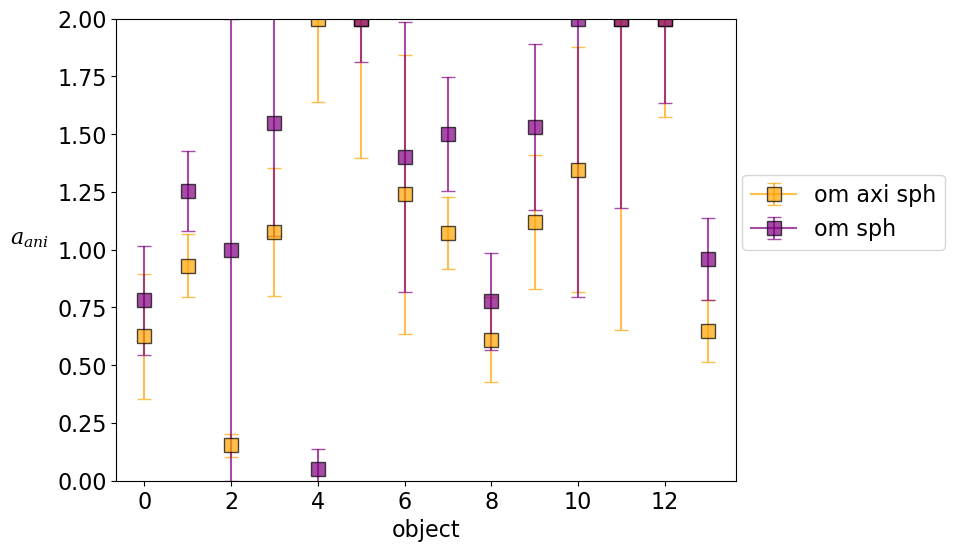

In [31]:
plt.figure(figsize=(8,6))

for i, model in enumerate(anis[3:]):
    
    for j, ani in enumerate(model):
        
        ani_err = ani_errs[i+3,j]
        
        if j==len(model)-1:
            label = pl_labels[i+3]
        else:
            label = None
            
        alpha=0.7
        # plot
        #plt.errorbar(x, gamma, yerr=gamma_err, label=file)
        plt.errorbar(j, ani, yerr=ani_err, label=label, alpha=alpha, color=pl_colors[i+3], markeredgecolor='k', markersize=10, marker=marker, capsize=5)
        
plt.legend(loc=(1.01,0.5))
#plt.ylim(-2.5, -1.4)
plt.ylabel(r'$a_{ani}$', rotation='horizontal', labelpad=20)
plt.xlabel('object')
plt.ylim(0., 2.)

In [32]:
anis[3:]

array([[0.62528256, 0.93137864, 0.15273913, 1.07829233, 2.        ,
        2.        , 1.23919555, 1.07362191, 0.61131514, 1.11860863,
        1.34573258, 2.        , 2.        , 0.64926587],
       [0.78058512, 1.25478962, 1.        , 1.54724742, 0.04909246,
        2.        , 1.40100095, 1.50037674, 0.7764119 , 1.53212998,
        2.        , 2.        , 2.        , 0.96122224]])

# Put both the slope and anisotropy together

/tmp/ipykernel_16349/4037946623.py:40: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(beta, -gamma, label=label, alpha=alpha, color=pl_colors[i], edgecolor='k', s=100, marker=marker)


(1.4, 2.4)

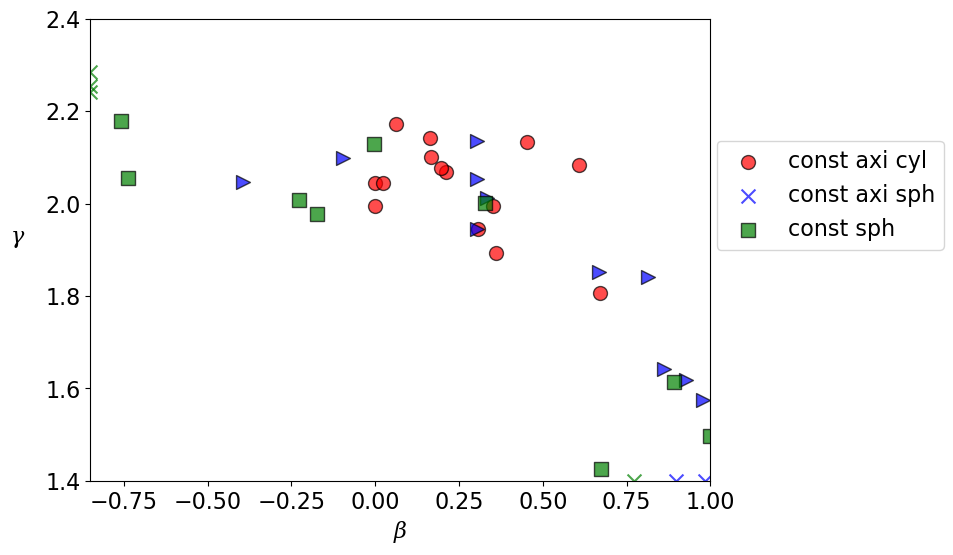

In [33]:
# Look at only constant anis

plt.figure(figsize=(8,6))

for i, model in enumerate(anis[:3]):
    
    gamma_model = gammas[i]
    
    for j, ani in enumerate(model):
        
        marker=pl_markers[i]
        
        # take the beta value
        beta = 1-ani**2
        beta_err = np.sqrt(np.square(2 * beta * ani_err / ani))
        
        if beta==-3:
            marker='x'
            beta=-0.85
            beta_err=0
            markeredgecolor=pl_colors[i]
        else:
            marker=pl_markers[i]
            markeredgecolor='k'
        
        # take gamma value
        gamma = gamma_model[j]
        if gamma > -1.4:
            marker='x'
            gamma = -1.4
        
        if j==len(model)-1:
            label = pl_labels[i]
        else:
            label = None
        
        alpha=0.7
        # plot
        #plt.errorbar(x, gamma, yerr=gamma_err, label=file)
        plt.scatter(beta, -gamma, label=label, alpha=alpha, color=pl_colors[i], edgecolor='k', s=100, marker=marker)
        
plt.legend(loc='upper left')
plt.legend(loc=(1.01,0.5))
plt.ylabel(r'$\gamma$', rotation='horizontal', labelpad=20)
plt.xlabel(r'$\beta$')
plt.xlim(-0.85, 1)
plt.ylim(1.4, 2.4)#-2.4, -1.4)

(1.4, 2.4)

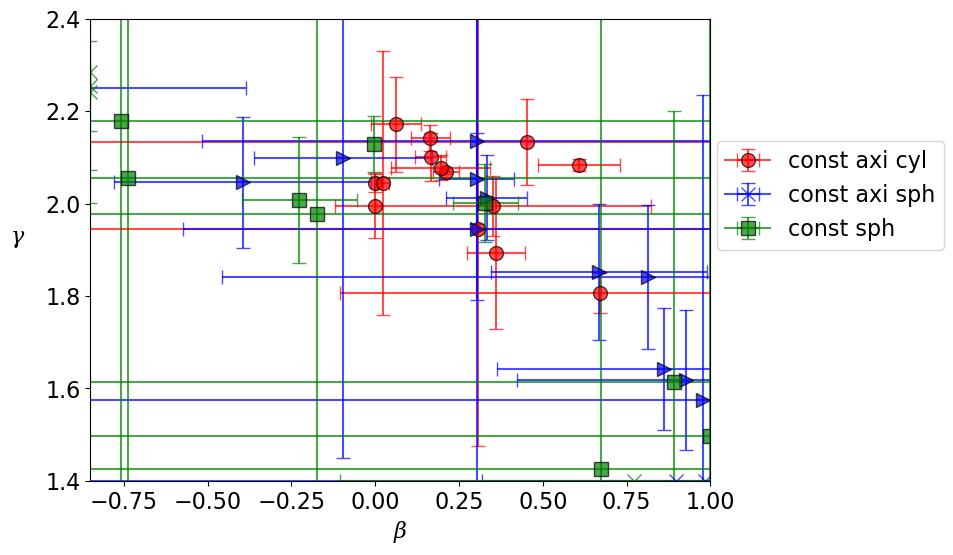

In [34]:
# Look at only constant anis

plt.figure(figsize=(8,6))

for i, model in enumerate(anis[:3]):
    
    gamma_model = gammas[i]
    
    for j, ani in enumerate(model):
        
        marker=pl_markers[i]
        markeredgecolor='k'
        
        # take the beta value
        beta = 1-ani**2
        beta_err = np.sqrt(np.square(2 * beta * ani_errs[i,j] / ani))
        
        if beta==-3:
            marker='x'
            beta=-0.85
            markeredgecolor=pl_colors[i]
            beta_err=0
        
        if j==len(model)-1:
            label = pl_labels[i]
        else:
            label = None
        
        # take gamma value
        gamma = gamma_model[j]
        gamma_err = gamma_errs[i,j]
        if gamma > -1.4:
            marker='x'
            gamma = -1.4
            gamma_err = 0
            markeredgecolor=pl_colors[i]
        
        alpha=0.7
        # plot
        #plt.errorbar(x, gamma, yerr=gamma_err, label=file)
        plt.errorbar(beta, -gamma, xerr=beta_err, yerr=gamma_err, label=label, alpha=alpha, color=pl_colors[i], markeredgecolor=markeredgecolor, markersize=10, marker=marker, capsize=5)
        
plt.legend(loc='upper left')
plt.legend(loc=(1.01,0.5))
plt.ylabel(r'$\gamma$', rotation='horizontal', labelpad=20)
plt.xlabel(r'$\beta$')
plt.xlim(-0.85, 1)
plt.ylim(1.4, 2.4)

(1.4, 2.4)

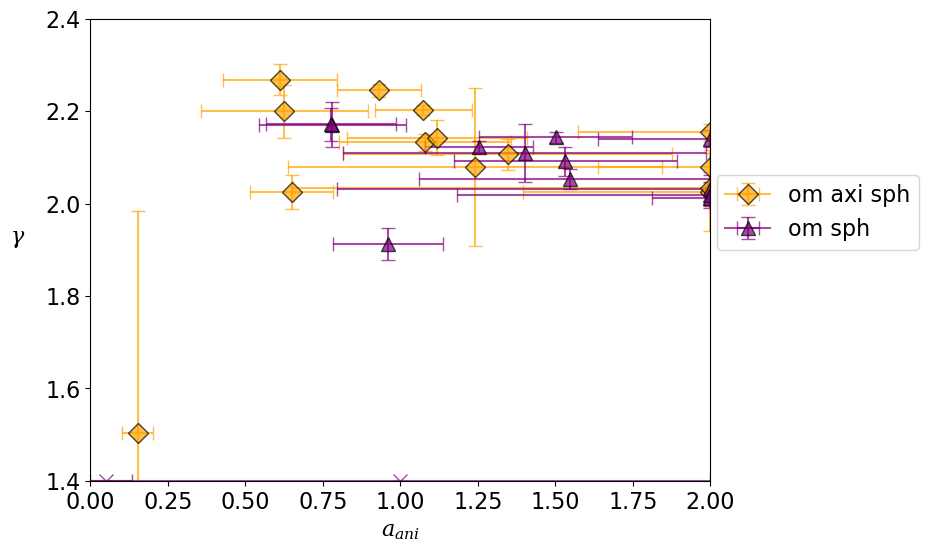

In [35]:
# Look at only constant anis

plt.figure(figsize=(8,6))

for i, model in enumerate(anis[3:]):
    
    gamma_model = gammas[i+3]
    
    for j, ani in enumerate(model):
        
        marker=pl_markers[i+3]
        markeredgecolor='k'
        
        # take the beta value
        ani_err = ani_errs[i+3,j]
        
        if j==len(model)-1:
            label = pl_labels[i+3]
        else:
            label = None
        
        # take gamma value
        gamma = gamma_model[j]
        gamma_err = gamma_errs[i+3,j]
        if gamma > -1.4:
            marker='x'
            gamma = -1.4
            gamma_err = 0
            markeredgecolor=pl_colors[i+3]
        
        alpha=0.7
        # plot
        #plt.errorbar(x, gamma, yerr=gamma_err, label=file)
        plt.errorbar(ani, -gamma, xerr=ani_err, yerr=gamma_err, label=label, alpha=alpha, color=pl_colors[i+3], markeredgecolor=markeredgecolor, markersize=10, marker=marker, capsize=5)
        
plt.legend(loc='upper left')
plt.legend(loc=(1.01,0.5))
plt.ylabel(r'$\gamma$', rotation='horizontal', labelpad=20)
plt.xlabel(r'$a_{ani}$')
plt.xlim(0.0, 2.0)
plt.ylim(1.4, 2.4)

# Chi2s

# Compare the 5 PL models

In [36]:
chi2s = np.zeros_like(gammas)

for i, file in enumerate(pl_sol):
    
    # get the solutions
    solutions = np.genfromtxt(file)
    
    
    # gamma and gamma_err are index 3 and 4
    chi2 = solutions[:,-1]
    
    chi2s[i] = chi2
    

In [37]:
# number of parameters in each model

# const axi cyl - q, ratio, gamma
# const axi sph - q, ratio, gamma
# const sph sph - ratio, gamma
# om axi sph - q, ani, gamma
# om sph sph - ani, gamma

ks = np.array([3, 3, 2, 3, 2])

In [38]:
# number of datapoints in each object
ns = np.ones((len(obj_names), len(ks)))

for i in range(len(obj_names)):

    obj_name = obj_names[i]
    obj_abbr = obj_name[4:9]

    
    SN = 15

    if obj_abbr=='J0330':
        file_dir = f'{kinematics_dir}{obj_name}/target_sn_{SN}/{obj_name}_{SN}_final_kinematics/no_g/'
    else:
        file_dir = f'{kinematics_dir}{obj_name}/target_sn_{SN}/{obj_name}_{SN}_marginalized_gnog_final_kinematics/'
        
    surf_lum, sigma_lum, qobs_lum, wrong_psf, Vrms, dVrms, V_bin, dV_bin, xbin, ybin, reff = prepare_to_jam(obj_name, file_dir, SN)
    
    n = len(Vrms)
    ns[i] = np.ones(len(ks))*n

In [39]:
bics = ks * np.log(ns) + chi2s.T

In [40]:
bics

array([[166.72799924, 164.27479331, 159.68457947, 164.42974791,
        156.29155355],
       [273.33223605, 278.95400753, 263.19779952, 277.0981523 ,
        262.31353802],
       [ 31.50470771,  32.789814  ,  29.05470346,  27.58325352,
          7.59167373],
       [ 26.31310442,  27.59499683,  23.64817122,  40.34484337,
         22.95201414],
       [286.64197947, 286.64752901, 282.42503329, 300.78250909,
        296.90714421],
       [254.89057395, 224.72548363, 218.34398631, 394.75182698,
        378.83252538],
       [196.9943586 , 204.62121553, 194.60044949, 205.75958915,
        193.48521432],
       [203.8100376 , 199.2145954 , 199.1742228 , 237.55402827,
        205.23214078],
       [ 76.19193034,  76.70066966,  80.25784039,  71.19494959,
         77.336162  ],
       [111.07007944, 116.4647411 , 104.78891048, 109.37137882,
        101.47963379],
       [124.80296799, 124.74706031, 126.03614161, 124.05578064,
        127.80846937],
       [172.03595713, 171.91371744, 174.799

In [41]:
delta_bics = (bics.T-np.min(bics, axis=1)).T

In [42]:
delta_bics

array([[1.04364457e+01, 7.98323977e+00, 3.39302592e+00, 8.13819437e+00,
        0.00000000e+00],
       [1.10186980e+01, 1.66404695e+01, 8.84261498e-01, 1.47846143e+01,
        0.00000000e+00],
       [2.39130340e+01, 2.51981403e+01, 2.14630297e+01, 1.99915798e+01,
        0.00000000e+00],
       [3.36109028e+00, 4.64298269e+00, 6.96157084e-01, 1.73928292e+01,
        0.00000000e+00],
       [4.21694618e+00, 4.22249572e+00, 0.00000000e+00, 1.83574758e+01,
        1.44821109e+01],
       [3.65465876e+01, 6.38149732e+00, 0.00000000e+00, 1.76407841e+02,
        1.60488539e+02],
       [3.50914428e+00, 1.11360012e+01, 1.11523517e+00, 1.22743748e+01,
        0.00000000e+00],
       [4.63581480e+00, 4.03725944e-02, 0.00000000e+00, 3.83798055e+01,
        6.05791798e+00],
       [4.99698075e+00, 5.50572008e+00, 9.06289081e+00, 0.00000000e+00,
        6.14121241e+00],
       [9.59044564e+00, 1.49851073e+01, 3.30927669e+00, 7.89174503e+00,
        0.00000000e+00],
       [7.47187343e-01, 6.9127

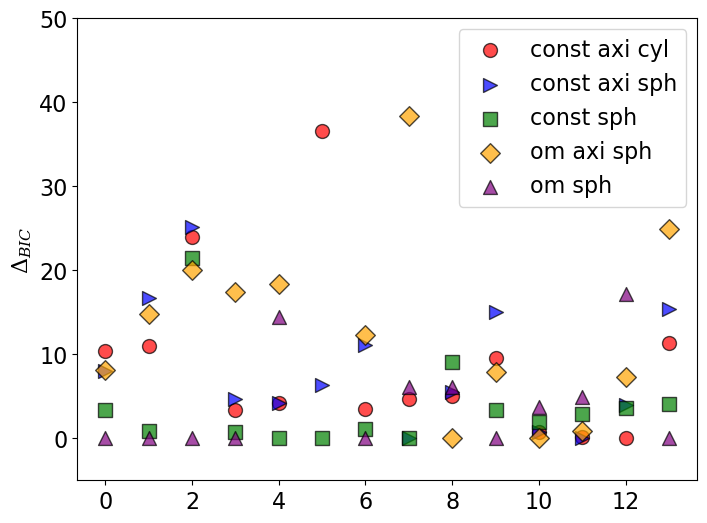

In [43]:
for i, delta_bic in enumerate(delta_bics.T):
    
    marker=pl_markers[i]
    
    plt.scatter(range(14), delta_bic, label=pl_labels[i], alpha=alpha, color=pl_colors[i], edgecolor='k', s=100, marker=marker)

plt.ylim(-5, 50)
plt.ylabel(r'$\Delta_{BIC}$', fontsize=16)
plt.legend(fontsize=16)

# Histograms

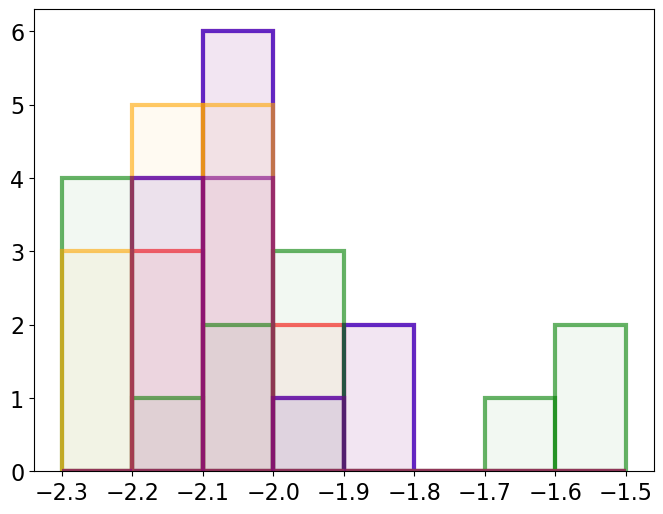

In [223]:
bins = np.arange(-2.3, -1.4, 0.1)

for i, model in enumerate(gammas):
    
    plt.hist(model, facecolor=pl_colors[i], bins=bins, alpha=0.05, edgecolor=None)
    plt.hist(model, facecolor='None', bins=bins, alpha=0.6, edgecolor=pl_colors[i], linewidth=3)

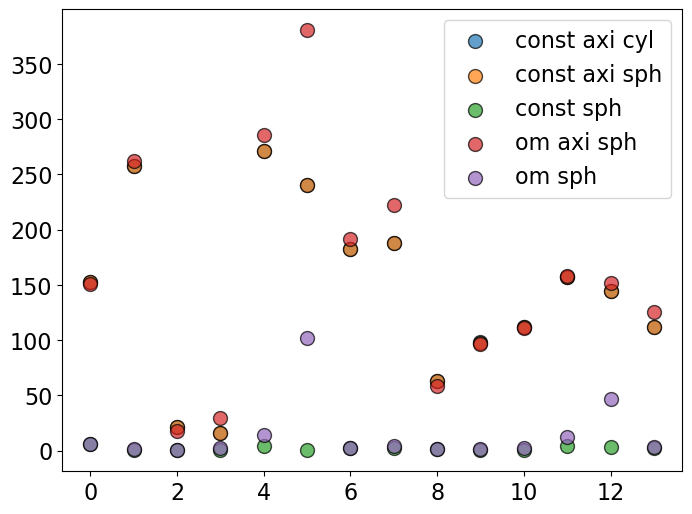

In [228]:
plt.figure(figsize=(8,6))

for i, file in enumerate(pl_sol):
    
    # get the solutions
    solutions = np.genfromtxt(file)
    
    
    # gamma and gamma_err are index 3 and 4
    chi2 = solutions[:,-1]
    
    alpha=0.7
    # plot
    x = range(14)
    #plt.errorbar(x, gamma, yerr=gamma_err, label=file)
    plt.scatter(x, chi2, label=pl_labels[i], alpha=alpha, edgecolor='k', s=100)
    plt.legend()
    #plt.ylim(-2.5, -1.4)
    

## Axisymmetric Cylindrical PL

In [ ]:
for i in range(1):#len(obj_names)):

    obj_name = obj_names[i]
    obj_abbr = obj_name[4:9]
    
    print('######################')
    print()
    print(obj_name)
    print()
    
    SN = 15
    mass_model='power_law'
    anisotropy='const'
    geometry='axi'
    align='cyl'
    zlens= zlenses[slacs_ix_table['Name']==obj_name]
    zsource = zsources[slacs_ix_table['Name']==obj_name]
    sigmapsf = sigmapsf_table[sigmapsf_table['obj_name']==obj_name]['kcwi_sigmapsf'].to_numpy()[0]
    theta_E = lens_models[lens_models['obj_name']==obj_name]['theta_E'].to_numpy()[0]
    cosmo = cosmo
    distance = cosmo.angular_diameter_distance(zlens).to_numpy()[0]
    fast_slow = paper_table.loc[0, 'class_for_JAM_models']
    
    if obj_abbr=='J0330':
        file_dir = f'{kinematics_dir}{obj_name}/target_sn_{SN}/{obj_name}_{SN}_final_kinematics/no_g/'
    else:
        file_dir = f'{kinematics_dir}{obj_name}/target_sn_{SN}/{obj_name}_{SN}_marginalized_gnog_final_kinematics/'
        
    surf_lum, sigma_lum, qobs_lum, wrong_psf, Vrms, dVrms, V_bin, dV_bin, xbin, ybin, reff = prepare_to_jam(obj_name, file_dir, SN)

    goodbins = np.isfinite(Vrms/dVrms)
    
    # cut out the bad bins
    Vrms = Vrms[goodbins]
    dVrms = dVrms[goodbins]
    xbin = xbin[goodbins]
    ybin = ybin[goodbins]
    
    # Starting guesses
    q0 = np.median(qobs_lum)
    ratio0 = 1          # Anisotropy ratio sigma_z/sigma_R
    gamma0 = -2         # Total mass logarithmic slope rho = r^gamma
    normpsf= 1
    
    qmin = np.min(qobs_lum)
    p0 = [q0, ratio0, gamma0]
    bounds = [[0.051, 0.01, -4], [qmin, 1, 0]]
    goodbins = np.isfinite(xbin)  # Here I fit all bins

    # These parameters are passed to JAM
    kwargs = {'surf_lum': surf_lum, 'sigma_lum': sigma_lum, 'qobs_lum': qobs_lum,
              'distance': distance, 'xbin': xbin, 'ybin': ybin, 'sigmapsf': sigmapsf,
              'normpsf': normpsf, 'rms': Vrms, 'erms': dVrms, 'pixsize': kcwi_scale,#pixsize,
              'goodbins': goodbins, 'align':align, 'plot': 0, 'return_mge': False}

    sol = 
    # bestfit paramters
    q = sol.x[0]
    inc = np.degrees(np.arctan2(np.sqrt(1 - qmin**2), np.sqrt(qmin**2 - q**2)))
    anis_ratio = sol.x[1]
    gamma_fit = sol.x[2]
    print('Best fit,', anis_ratio, gamma_fit)
    
    # covariance matrix of free parameters
    cov = sol.cov
    # qerr doesn't matter but is the first index
    anis_ratio_err = np.sqrt(sol.cov.diagonal()[1])
    gamma_err = np.sqrt(sol.cov.diagonal()[2])
    
    # plot the best fit
    kwargs['plot'] = 1
    kwargs['return_mge'] = True
    surf_pot, sigma_pot, qobs_pot, chi2 = jam_resid(sol.x, **kwargs)
    plt.savefig(f'{jam_output_dir}{obj_name}_pl_const_axicyl_fit.png')
    plt.pause(1)
    plt.clf()
    
    # take chi2/dof
    #dof = len(Vrms)
    #chi2_red = chi2/dof
    
    # calculate the enclosed mass
    mass_enclosed, gamma_avg, profile_radii, profile_1d \
                = calculate_mass_and_slope_enclosed(surf_pot, sigma_pot, qobs_pot, distance, radius=theta_E, plot=True)
    
    print('Mass enclosed, avg gamma', mass_enclosed, gamma_avg)
    
    pl_const_axicyl_solutions[i] = np.array([inc, 
                                             anis_ratio, anis_ratio_err, 
                                             gamma_fit, gamma_err, 
                                             gamma_avg, mass_enclosed, 
                                             chi2])
    pl_const_axicyl_cov[i] = cov
    pl_const_axicyl_mass_profiles_r[i] = profile_radii
    pl_const_axicyl_mass_profiles[i] = profile_1d

In [ ]:
# save with header
sol_header = '#### 14 objects - inc, anis_ratio, anis_ratio_err, gamma_fit, gamma_err, gamma_avg, mass_enclosed, chi2'
np.savetxt(f'{jam_output_dir}jam_pl_const_axicyl_solutions_02072024.txt', pl_const_axicyl_solutions, header=sol_header) 
np.savetxt(f'{jam_output_dir}jam_pl_const_axicyl_covariances_02072024.txt', pl_const_axicyl_cov.reshape(14,9), header='covariance matrix has been reshaped to 2D, reshape back to (14,3,3)') 

profile_header = '#### radius, surface mass density (Msol/pc2), has been reshaped to 2D, reshape back to (14,50,2)'
pl_const_axicyl_mass_profile_joined = np.dstack((pl_const_axicyl_mass_profiles_r, pl_const_axicyl_mass_profiles)).reshape(14, 100)
np.savetxt(f'{jam_output_dir}jam_pl_const_axicyl_profiles_02072024.txt', pl_const_axicyl_mass_profile_joined, header=profile_header) 

## Axisymmetric Spherical PL

In [ ]:
for i in range(1):#len(obj_names)):

    obj_name = obj_names[i]
    obj_abbr = obj_name[4:9]
    
    print('######################')
    print()
    print(obj_name)
    print()
    
    # Model
    SN = 15
    mass_model='power_law'
    anisotropy='const'
    geometry='axi'
    align='cyl'
    
    # object attributes
    zlens= zlenses[slacs_ix_table['Name']==obj_name]
    zsource = zsources[slacs_ix_table['Name']==obj_name]
    sigmapsf = sigmapsf_table[sigmapsf_table['obj_name']==obj_name]['kcwi_sigmapsf'].to_numpy()[0]
    theta_E = lens_models[lens_models['obj_name']==obj_name]['theta_E'].to_numpy()[0]
    cosmo = cosmo
    distance = cosmo.angular_diameter_distance(zlens).to_numpy()[0]
    fast_slow = paper_table.loc[0, 'class_for_JAM_models']
    
    if obj_abbr=='J0330':
        file_dir = f'{kinematics_dir}{obj_name}/target_sn_{SN}/{obj_name}_{SN}_final_kinematics/no_g/'
    else:
        file_dir = f'{kinematics_dir}{obj_name}/target_sn_{SN}/{obj_name}_{SN}_marginalized_gnog_final_kinematics/'
        
    surf_lum, sigma_lum, qobs_lum, wrong_psf, Vrms, dVrms, V_bin, dV_bin, xbin, ybin, reff = prepare_to_jam(obj_name, file_dir, SN)
    
    goodbins = np.isfinite(Vrms/dVrms)
    
    # cut out the bad bins
    Vrms = Vrms[goodbins]
    dVrms = dVrms[goodbins]
    xbin = xbin[goodbins]
    ybin = ybin[goodbins]
    
    # Starting guesses
    q0 = np.median(qobs_lum)
    ratio0 = 1          # Anisotropy ratio sigma_z/sigma_R
    gamma0 = -2         # Total mass logarithmic slope rho = r^gamma
    normpsf= 1
    
    qmin = np.min(qobs_lum)
    p0 = [q0, ratio0, gamma0]
    bounds = [[0.051, 0.01, -4], [qmin, 2.0, 0]]
    goodbins = np.isfinite(xbin)  # Here I fit all bins

    # These parameters are passed to JAM
    kwargs = {'surf_lum': surf_lum, 'sigma_lum': sigma_lum, 'qobs_lum': qobs_lum,
              'distance': distance, 'xbin': xbin, 'ybin': ybin, 'sigmapsf': sigmapsf,
              'normpsf': normpsf, 'rms': Vrms, 'erms': dVrms, 'pixsize': kcwi_scale,#pixsize,
              'goodbins': goodbins, 'align':align, 'plot': 0, 'return_mge': False}

    sol = capfit(jam_resid, p0, kwargs=kwargs, bounds=bounds, verbose=2, fixed=[0, 0, 0])
    if sol.success==True:
        print()
        print('Success!')
        print()
    else:
        print()
        print('Fit failed to meet convergence criteria.')
        print()
        
    # bestfit paramters
    q = sol.x[0]
    inc = np.degrees(np.arctan2(np.sqrt(1 - qmin**2), np.sqrt(qmin**2 - q**2)))
    anis_ratio = sol.x[1]
    gamma_fit = sol.x[2]
    print('Best fit,', anis_ratio, gamma_fit)
    
    # covariance matrix of free parameters
    cov = sol.cov
    # qerr doesn't matter but is the first index
    anis_ratio_err = np.sqrt(sol.cov.diagonal()[1])
    gamma_err = np.sqrt(sol.cov.diagonal()[2])
    
    
    # plot the best fit
    kwargs['plot'] = 1
    kwargs['return_mge'] = True
    surf_pot, sigma_pot, qobs_pot, chi2 = jam_resid(sol.x, **kwargs)
    plt.savefig(f'{jam_output_dir}{obj_name}_pl_const_axisph_fit.png')
    plt.pause(1)
    
    # take chi2/dof
    #dof = len(Vrms)
    #chi2_red = chi2/dof
    
    # calculate the enclosed mass
    mass_enclosed, gamma_avg, profile_radii, profile_1d \
                = calculate_mass_and_slope_enclosed(surf_pot, sigma_pot, qobs_pot, distance, radius=theta_E, plot=True)
    
    print('Mass enclosed, avg gamma', mass_enclosed, gamma_avg)
    
    pl_const_axisph_solutions[i] = np.array([inc, 
                                             anis_ratio, anis_ratio_err, 
                                             gamma_fit, gamma_err, 
                                             gamma_avg, mass_enclosed, 
                                             chi2])
    pl_const_axisph_cov[i] = cov
    pl_const_axisph_mass_profiles_r[i] = profile_radii
    pl_const_axisph_mass_profiles[i] = profile_1d

In [ ]:
# save with header
sol_header = '#### 14 objects - inc, anis_ratio, anis_ratio_err, gamma_fit, gamma_err, gamma_avg, mass_enclosed, chi2'
np.savetxt(f'{jam_output_dir}jam_pl_const_axisph_solutions_02072024.txt', pl_const_axisph_solutions, header=sol_header) 
np.savetxt(f'{jam_output_dir}jam_pl_const_axisph_covariances_02072024.txt', pl_const_axisph_cov.reshape(14,9), header='covariance matrix has been reshaped to 2D, reshape back to (14,3,3)') 

pl_const_axisph_mass_profile_joined = np.dstack((pl_const_axisph_mass_profiles_r, pl_const_axisph_mass_profiles)).reshape(14, 100)
np.savetxt(f'{jam_output_dir}jam_pl_const_axisph_profiles_02072024.txt', pl_const_axisph_mass_profile_joined, header=profile_header) 

## Spherical Geometry PL

In [ ]:
# spherical models require my 1D kinematics
# as in e.g. data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/milestone23_data/SDSSJ0029-0055/SDSSJ0029-0055_kinmap.csv

In [ ]:
###############################################################################

def jam_resid_sph(pars, surf_lum=None, sigma_lum=None,
                  distance=None, rbin=None,
                   sigmapsf=None, normpsf=None, 
                  rms=None, erms=None, pixsize=None, plot=True, return_mge=False):

    ratio, gamma = pars

    beta = np.full_like(surf_lum, 1 - ratio**2)   # assume constant anisotropy

    #rbreak = 20e3              # Adopt fixed halo break radius of 20 kpc (much larger than the data)
    #pc = distance*np.pi/0.648   # Constant factor to convert arcsec --> pc
    #rbreak /= pc
    # Convert the break radius from pc --> arcsec
    rbreak = 50 #20*reff
    mbh = 0                     # Ignore the central black hole
    surf_pot, sigma_pot, qobs_pot = total_mass_mge_cap(gamma, rbreak)

    jam = jam_sph_proj(surf_lum, sigma_lum, surf_pot, sigma_pot,
                       mbh, distance, rbin,
                       sigmapsf=sigmapsf, normpsf=normpsf,
                      beta=beta, data=rms, errors=erms, 
                       plot=plot, pixsize=pixsize, quiet=1, ml=None)
    
    resid = (rms - jam.model)/erms
    chi2 = np.sum(resid**2)
    
    if return_mge==True:
        
        # return the mass mge multiplied by the ml from jam
        return surf_pot*jam.ml, sigma_pot, qobs_pot, chi2
    
    else:
        return resid   # ln(likelihood) + cost.

In [ ]:
pl_const_sphsph_solutions = np.ones((len(obj_names), 8))
pl_const_sphsph_cov = np.ones((len(obj_names), 2, 2))
pl_const_sphsph_mass_profiles_r = np.ones((len(obj_names), 50))
pl_const_sphsph_mass_profiles = np.ones((len(obj_names), 50))

In [ ]:
for i in range(1):#len(obj_names)):

    obj_name = obj_names[i]
    obj_abbr = obj_name[4:9]
    
    print('######################')
    print()
    print(obj_name)
    print()
    
    if obj_abbr=='J0330':
        print('J0330 is not reliable and will not be used here.')
        print()
        continue
    
    SN = 15
    mass_model='power_law'
    anisotropy='const'
    geometry='sph'
    zlens= zlenses[slacs_ix_table['Name']==obj_name]
    zsource = zsources[slacs_ix_table['Name']==obj_name]
    sigmapsf = sigmapsf_table[sigmapsf_table['obj_name']==obj_name]['kcwi_sigmapsf'].to_numpy()[0]
    theta_E = lens_models[lens_models['obj_name']==obj_name]['theta_E'].to_numpy()[0]
    cosmo = cosmo
    distance = cosmo.angular_diameter_distance(zlens).to_numpy()[0]
    fast_slow = paper_table.loc[0, 'class_for_JAM_models']
    
    # load in the 1D kinematics
    Vrms_1d = pd.read_csv(f'{milestone_dir}{obj_name}/{obj_name}_kinmap.csv')
    Vrms = Vrms_1d['binned_Vrms'].to_numpy()
    rbin = np.mean(Vrms_1d[['bin_inner_edge','bin_outer_edge']].to_numpy(), axis=1)
    Vrms_cov = np.loadtxt(f'{milestone_dir}{obj_name}/{obj_name}_kinmap_cov.csv', delimiter=',', dtype=float)
    dVrms = np.sqrt(Vrms_cov.diagonal())
    
    if obj_abbr=='J0330':
        file_dir = f'{kinematics_dir}{obj_name}/target_sn_{SN}/{obj_name}_{SN}_final_kinematics/no_g/'
    else:
        file_dir = f'{kinematics_dir}{obj_name}/target_sn_{SN}/{obj_name}_{SN}_marginalized_gnog_final_kinematics/'
        
    surf_lum, sigma_lum, _, _, _, _, _, _, _, _, reff = prepare_to_jam(obj_name, file_dir, SN)
    
    # Starting guesses
    ratio0 = 1          # Anisotropy ratio sigma_z/sigma_R
    gamma0 = -2         # Total mass logarithmic slope rho = r^gamma
    
    normpsf= 1  
    p0 = [ratio0, gamma0]
    bounds = [[0.01, -4], [2.0, 0]]

    # These parameters are passed to JAM
    kwargs = {'surf_lum': surf_lum, 'sigma_lum': sigma_lum,
              'distance': distance, 'rbin':rbin, 
              'sigmapsf': sigmapsf, 'normpsf': normpsf, 
              'rms': Vrms, 'erms': dVrms, 
              'pixsize': kcwi_scale,#pixsize,
              'plot': 0, 'return_mge': False}

    sol = capfit(jam_resid_sph, p0, kwargs=kwargs, bounds=bounds, verbose=2, fixed=[0, 0])
    if sol.success==True:
        print()
        print('Success!')
        print()
    else:
        print()
        print('Fit failed to meet convergence criteria.')
        print()
    
    # bestfit paramters
    anis_ratio = sol.x[0]
    gamma_fit = sol.x[1]
    print('Best fit,', anis_ratio, gamma_fit)
    
    # covariance matrix of free parameters
    cov = sol.cov
    anis_ratio_err = np.sqrt(sol.cov.diagonal()[0])
    gamma_err = np.sqrt(sol.cov.diagonal()[1])
    
    # plot the bestfit
    kwargs['plot'] = 1
    kwargs['return_mge'] = True
    surf_pot, sigma_pot, qobs_pot, chi2 = jam_resid_sph(sol.x, **kwargs)
    plt.savefig(f'{jam_output_dir}{obj_name}_pl_const_sphsph_fit.png')
    plt.pause(1)
    
    # take chi2/dof
    #dof = len(Vrms)
    #chi2_red = chi2/dof
    
    # calculate the enclosed mass
    mass_enclosed, gamma_avg, profile_radii, profile_1d = calculate_mass_and_slope_enclosed(surf_pot, sigma_pot, qobs_pot, distance, radius=theta_E, plot=True)
    
    print('Mass enclosed, avg gamma', mass_enclosed, gamma_avg)
    
    inc=np.nan
    
    pl_const_sphsph_solutions[i] = np.array([inc, anis_ratio, anis_ratio_err, gamma_fit, gamma_err, gamma_avg, mass_enclosed, chi2])
    pl_const_sphsph_cov[i] = cov
    pl_const_sphsph_mass_profiles_r[i] = profile_radii
    pl_const_sphsph_mass_profiles[i] = profile_1d

In [ ]:
# save with header
sol_header = '#### 14 objects - inc, anis_ratio, anis_ratio_err, gamma_fit, gamma_err, gamma_avg, mass_enclosed, chi2'
np.savetxt(f'{jam_output_dir}jam_pl_const_sphsph_solutions_02072024.txt', pl_const_sphsph_solutions, header=sol_header) 
np.savetxt(f'{jam_output_dir}jam_pl_const_sphsph_covariances_02072024.txt', pl_const_sphsph_cov.reshape(14,4), header='covariance matrix has been reshaped to 2D, reshape back to (14,3,3)') 

pl_const_sphsph_mass_profile_joined = np.dstack((pl_const_sphsph_mass_profiles_r, pl_const_sphsph_mass_profiles)).reshape(14, 100)
np.savetxt(f'{jam_output_dir}jam_pl_const_sphsph_profiles_02072024.txt', pl_const_sphsph_mass_profile_joined, header=profile_header) 

# PL, Osipkov-Merrit

In [ ]:
###############################################################################

def jam_resid_sph_OM(pars, surf_lum=None, sigma_lum=None,
                      distance=None, rbin=None,
                       sigmapsf=None, normpsf=None, 
                      rms=None, erms=None, pixsize=None, plot=True, return_mge=False):
    
    # OM uses anisotropy radius instead of the ratio
    a_ani, gamma = pars
    rani = reff * a_ani

    rbreak = 20*reff
    mbh = 0                     # Ignore the central black hole
    surf_pot, sigma_pot, qobs_pot = total_mass_mge_cap(gamma, rbreak)

    jam = jam_sph_proj(surf_lum, sigma_lum, surf_pot, sigma_pot,
                       mbh, distance, rbin,
                       sigmapsf=sigmapsf, normpsf=normpsf,
                       rani=rani, data=rms, errors=erms, 
                       plot=plot, pixsize=pixsize, quiet=1, ml=None)
    
    resid = (rms - jam.model)/erms
    chi2 = np.sum(resid**2)
    
    if return_mge==True:
        
        # return the mass mge multiplied by the ml from jam
        return surf_pot*jam.ml, sigma_pot, qobs_pot, chi2
    
    else:
        return resid   # ln(likelihood) + cost.

In [ ]:
###############################################################################

def jam_resid_axi_OM(pars, surf_lum=None, sigma_lum=None, qobs_lum=None, 
                      distance=None, align=None, goodbins=None,
                      xbin=None, ybin=None, sigmapsf=None, normpsf=None, 
                      rms=None, erms=None, pixsize=None, plot=True, return_mge=False):
    
    #### OM should only be done with spherical alignment
    
    q, a_ani, gamma = pars
    rani = a_ani * reff
    
    # Sample inclination using min(q), with Equation (14) of Cappellari (2008)
    qmin = np.min(qobs_lum)
    inc = np.degrees(np.arctan2(np.sqrt(1 - qmin**2), np.sqrt(qmin**2 - q**2)))
    beta= [rani, 0, 1, 2]

    rbreak = 50 #20*reff
    mbh = 0                     # Ignore the central black hole
    surf_pot, sigma_pot, qobs_pot = total_mass_mge_cap(gamma, rbreak)

    jam = jam_axi_proj(surf_lum, sigma_lum, qobs_lum, surf_pot, sigma_pot, qobs_pot,
                       inc, mbh, distance, xbin, ybin, plot=plot, pixsize=pixsize, quiet=1,
                       sigmapsf=sigmapsf, normpsf=normpsf, goodbins=goodbins, align=align,
                       beta=beta, data=rms, errors=erms, ml=None, logistic=True)
    resid = (rms[goodbins] - jam.model[goodbins])/erms[goodbins]
    chi2 = np.sum(resid**2)
    
    if return_mge==True:
        
        # return the mass mge multiplied by the ml from jam
        return surf_pot*jam.ml, sigma_pot, qobs_pot, chi2
    
    else:
        return resid   # ln(likelihood) + cost.

In [ ]:
# will need the fit parameters, average slopes, enclosed masses, and uncertainties on fit parameters

# np.array([inc, a_ani, a_ani_err, gamma_fit, gamma_err, gamma_avg, mass_enclosed, chi2_red])
pl_om_sphsph_solutions = np.ones((len(obj_names), 8))
pl_om_sphsph_cov = np.ones((len(obj_names), 2, 2))
pl_om_sphsph_mass_profiles_r = np.ones((len(obj_names), 50))
pl_om_sphsph_mass_profiles = np.ones((len(obj_names), 50))

# np.array([inc, a_ani, a_ani_err, gamma_fit, gamma_err, gamma_avg, mass_enclosed, chi2_red])
pl_om_axisph_solutions = np.ones((len(obj_names), 8))
pl_om_axisph_cov = np.ones((len(obj_names), 3, 3))
pl_om_axisph_mass_profiles_r = np.ones((len(obj_names), 50))
pl_om_axisph_mass_profiles = np.ones((len(obj_names), 50))

## OM PL spherical geometry

In [ ]:
for i in range(1):#len(obj_names)):

    obj_name = obj_names[i]
    obj_abbr = obj_name[4:9]
    
    print('######################')
    print()
    print(obj_name)
    print()
    
    if obj_abbr=='J0330':
        print('J0330 is not reliable and will not be used here.')
        print()
        continue
    
    SN = 15
    mass_model='power_law'
    anisotropy='om'
    geometry='sph'
    zlens= zlenses[slacs_ix_table['Name']==obj_name]
    zsource = zsources[slacs_ix_table['Name']==obj_name]
    sigmapsf = sigmapsf_table[sigmapsf_table['obj_name']==obj_name]['kcwi_sigmapsf'].to_numpy()[0]
    theta_E = lens_models[lens_models['obj_name']==obj_name]['theta_E'].to_numpy()[0]
    cosmo = cosmo
    distance = cosmo.angular_diameter_distance(zlens).to_numpy()[0]
    fast_slow = paper_table.loc[0, 'class_for_JAM_models']
    
    # load in the 1D kinematics
    Vrms_1d = pd.read_csv(f'{milestone_dir}{obj_name}/{obj_name}_kinmap.csv')
    Vrms = Vrms_1d['binned_Vrms'].to_numpy()
    rbin = np.mean(Vrms_1d[['bin_inner_edge','bin_outer_edge']].to_numpy(), axis=1)
    Vrms_cov = np.loadtxt(f'{milestone_dir}{obj_name}/{obj_name}_kinmap_cov.csv', delimiter=',', dtype=float)
    dVrms = np.sqrt(Vrms_cov.diagonal())
    
    if obj_abbr=='J0330':
        file_dir = f'{kinematics_dir}{obj_name}/target_sn_{SN}/{obj_name}_{SN}_final_kinematics/no_g/'
    else:
        file_dir = f'{kinematics_dir}{obj_name}/target_sn_{SN}/{obj_name}_{SN}_marginalized_gnog_final_kinematics/'
        
    surf_lum, sigma_lum, _, _, _, _, _, _, _, _, reff = prepare_to_jam(obj_name, file_dir, SN)
    
    # Starting guesses
    ani0 = 0.5          # Anisotropy ratio sigma_z/sigma_R
    gamma0 = -2         # Total mass logarithmic slope rho = r^gamma
    
    normpsf= 1  
    p0 = [ani0, gamma0]
    bounds = [[0.01, -4], [2.0, 0]]

    # These parameters are passed to JAM
    kwargs = {'surf_lum': surf_lum, 'sigma_lum': sigma_lum,
              'distance': distance, 'rbin':rbin, 
              'sigmapsf': sigmapsf, 'normpsf': normpsf, 
              'rms': Vrms, 'erms': dVrms, 
              'pixsize': kcwi_scale,#pixsize,
              'plot': 0, 'return_mge': False}
    
    # do the fit, take the solutions and covariance matrix
    sol = capfit(jam_resid_sph_OM, p0, kwargs=kwargs, bounds=bounds, verbose=2, fixed=[0, 0])
    if sol.success==True:
        print()
        print('Success!')
        print()
    else:
        print()
        print('Fit failed to meet convergence criteria.')
        print()
    # bestfit paramters
    a_ani = sol.x[0]
    gamma_fit = sol.x[1]
    # covariance matrix of free parameters
    cov = sol.cov
    a_ani_err = np.sqrt(sol.cov.diagonal()[0])
    gamma_err = np.sqrt(sol.cov.diagonal()[1])                    
    
    print('Best fit,', anis_ratio, gamma_fit)
    
    kwargs['plot'] = 1
    kwargs['return_mge'] = True
    surf_pot, sigma_pot, qobs_pot, chi2 = jam_resid_sph_OM(sol.x, **kwargs)
    plt.savefig(f'{jam_output_dir}{obj_name}_pl_om_sphsph_fit.png')
    plt.pause(1)
    
    # take chi2/dof
    #dof = len(Vrms)
    #chi2_red = chi2/dof
    
    # calculate the enclosed mass
    mass_enclosed, gamma_avg, profile_radii, profile_1d = calculate_mass_and_slope_enclosed(surf_pot, sigma_pot, qobs_pot, distance, radius=theta_E, plot=True)
    
    print('Mass enclosed, avg gamma', mass_enclosed, gamma_avg)
    
    inc=np.nan
    
    pl_om_sphsph_solutions[i] = np.array([inc, a_ani, a_ani_err, gamma_fit, gamma_err, gamma_avg, mass_enclosed, chi2])
    pl_om_sphsph_cov[i] = cov
    pl_om_sphsph_mass_profiles_r[i] = profile_radii
    pl_om_sphsph_mass_profiles[i] = profile_1d

In [ ]:
# save with header
sol_header = '#### 14 objects - inc, anis_radius, anis_radius_err, gamma_fit, gamma_err, gamma_avg, mass_enclosed, chi2'
np.savetxt(f'{jam_output_dir}jam_pl_om_sphsph_solutions_02072024.txt', pl_om_sphsph_solutions, header=sol_header) 
np.savetxt(f'{jam_output_dir}jam_pl_om_sphsph_covariances_02072024.txt', pl_om_sphsph_cov.reshape(14,4), header='covariance matrix has been reshaped to 2D, reshape back to (14,2,2)') 
 
pl_om_sphsph_mass_profile_joined = np.dstack((pl_om_sphsph_mass_profiles_r, pl_om_sphsph_mass_profiles)).reshape(14, 100)
np.savetxt(f'{jam_output_dir}jam_pl_om_sphsph_profiles_02072024.txt', pl_om_sphsph_mass_profile_joined, header=profile_header) 

## OM PL axisymmetric geometry

In [ ]:
for i in range(1):#len(obj_names)):

    obj_name = obj_names[i]
    obj_abbr = obj_name[4:9]
    
    print('######################')
    print()
    print(obj_name)
    print()
    
    SN = 15
    mass_model='power_law'
    anisotropy='om'
    geometry='axi'
    align='sph'
    zlens= zlenses[slacs_ix_table['Name']==obj_name]
    zsource = zsources[slacs_ix_table['Name']==obj_name]
    sigmapsf = sigmapsf_table[sigmapsf_table['obj_name']==obj_name]['kcwi_sigmapsf'].to_numpy()[0]
    theta_E = lens_models[lens_models['obj_name']==obj_name]['theta_E'].to_numpy()[0]
    cosmo = cosmo
    distance = cosmo.angular_diameter_distance(zlens).to_numpy()[0]
    fast_slow = paper_table.loc[0, 'class_for_JAM_models']
    
    if obj_abbr=='J0330':
        file_dir = f'{kinematics_dir}{obj_name}/target_sn_{SN}/{obj_name}_{SN}_final_kinematics/no_g/'
    else:
        file_dir = f'{kinematics_dir}{obj_name}/target_sn_{SN}/{obj_name}_{SN}_marginalized_gnog_final_kinematics/'
        
    surf_lum, sigma_lum, qobs_lum, wrong_psf, Vrms, dVrms, V_bin, dV_bin, xbin, ybin, reff = prepare_to_jam(obj_name, file_dir, SN)
    
    goodbins = np.isfinite(Vrms/dVrms)
    
    # cut out the bad bins
    Vrms = Vrms[goodbins]
    dVrms = dVrms[goodbins]
    xbin = xbin[goodbins]
    ybin = ybin[goodbins]
    
    # Starting guesses
    q0 = np.median(qobs_lum)
    ani0 = 0.5          # Anisotropy ratio sigma_z/sigma_R
    gamma0 = -2         # Total mass logarithmic slope rho = r^gamma
    normpsf= 1
    
    
    qmin = np.min(qobs_lum)
    p0 = [q0, ani0, gamma0]
    bounds = [[0.051, 0.01, -4], [qmin, 2.0, 0]]
    goodbins = np.isfinite(xbin)  # Here I fit all bins

    # These parameters are passed to JAM
    kwargs = {'surf_lum': surf_lum, 'sigma_lum': sigma_lum, 'qobs_lum': qobs_lum,
              'distance': distance, 'xbin': xbin, 'ybin': ybin, 'sigmapsf': sigmapsf,
              'normpsf': normpsf, 'rms': Vrms, 'erms': dVrms, 'pixsize': kcwi_scale,#pixsize,
              'goodbins': goodbins, 'align':align, 'plot': 0, 'return_mge': False}

    sol = capfit(jam_resid_axi_OM, p0, kwargs=kwargs, bounds=bounds, verbose=2, fixed=[0, 0, 0])
    # bestfit paramters
    q = sol.x[0]
    inc = np.degrees(np.arctan2(np.sqrt(1 - qmin**2), np.sqrt(qmin**2 - q**2)))
    a_ani = sol.x[1]
    gamma_fit = sol.x[2]
    # covariance matrix of free parameters
    cov = sol.cov
    q_err = np.sqrt(sol.cov.diagonal()[0])
    a_ani_err = np.sqrt(sol.cov.diagonal()[1])
    gamma_err = np.sqrt(sol.cov.diagonal()[2])   
    
    print('Best fit,', anis_ratio, gamma_fit)
    
    kwargs['plot'] = 1
    kwargs['return_mge'] = True
    surf_pot, sigma_pot, qobs_pot, chi2 = jam_resid_axi_OM(sol.x, **kwargs)
    plt.savefig(f'{jam_output_dir}{obj_name}_pl_om_axisph_fit.png')
    plt.pause(1)
    
    # take chi2/dof
    #dof = len(Vrms)
    #chi2_red = chi2/dof
    
    # calculate the enclosed mass
    mass_enclosed, gamma_avg, profile_radii, profile_1d = calculate_mass_and_slope_enclosed(surf_pot, sigma_pot, qobs_pot, distance, radius=theta_E, plot=True)
    
    print('Mass enclosed, avg gamma', mass_enclosed, gamma_avg)
    
    pl_om_axisph_solutions[i] = np.array([inc, a_ani, a_ani_err, gamma_fit, gamma_err, gamma_avg, mass_enclosed, chi2])
    pl_om_axisph_cov[i] = cov
    pl_om_axisph_mass_profiles_r[i] = profile_radii
    pl_om_axisph_mass_profiles[i] = profile_1d

In [ ]:
# save with header
sol_header = '#### 14 objects - inc, anis_radius, anis_radius_err, gamma_fit, gamma_err, gamma_avg, mass_enclosed, chi2'
np.savetxt(f'{jam_output_dir}jam_pl_om_axisph_solutions_02072024.txt', pl_om_axisph_solutions, header=sol_header) 
np.savetxt(f'{jam_output_dir}jam_pl_om_axisph_covariances_02072024.txt', pl_om_axisph_cov.reshape(14,9), header='covariance matrix has been reshaped to 2D, reshape back to (14,2,2)') 
 
pl_om_axisph_mass_profile_joined = np.dstack((pl_om_axisph_mass_profiles_r, pl_om_axisph_mass_profiles)).reshape(14, 100)
np.savetxt(f'{jam_output_dir}jam_pl_om_axisph_profiles_02072024.txt', pl_om_axisph_mass_profile_joined, header=profile_header) 

_____________________________
_____________________________
_____________________________
_____________________________
# MFL, constant anisotropy

In [ ]:
def jam_resid_mfl(pars, surf_lum=None, sigma_lum=None, qobs_lum=None, distance=None,
                  xbin=None, ybin=None, sigmapsf=None, normpsf=None, goodbins=None,
                  rms=None, erms=None, pixsize=None, align=None, plot=True, return_mge=False):

    q, ratio = pars

    # Sample inclination using min(q), with Equation (14) of Cappellari (2008)
    qmin = np.min(qobs_lum)
    inc = np.degrees(np.arctan2(np.sqrt(1 - qmin**2), np.sqrt(qmin**2 - q**2)))
    
    # anisotropy
    beta = np.full_like(qobs_lum, 1 - ratio**2)   # assume constant anisotropy
    
    # break radius (how far out we fit it)
    rbreak = 50 #20*reff
    mbh = 0 # Ignore the central black hole
    
    # take the surface brigbhtness profile as the mass prfoile, it will be scaled by some M/L
    surf_pot, sigma_pot, qobs_pot = surf_lum, sigma_lum, qobs_lum
    
    # do the fit
    jam = jam_axi_proj(surf_lum, sigma_lum, qobs_lum, surf_pot, sigma_pot, qobs_pot,
                       inc, mbh, distance, xbin, ybin, plot=plot, pixsize=pixsize, quiet=1,
                       sigmapsf=sigmapsf, normpsf=normpsf, goodbins=goodbins, align=align,
                       beta=beta, data=rms, errors=erms, ml=None)
    
    # get residual and chi2
    resid = (rms[goodbins] - jam.model[goodbins])/erms[goodbins]
    chi2 = np.sum(resid**2)
    
    if return_mge==True:
        
        # return the mass mge multiplied by the ml from jam
        return surf_pot*jam.ml, sigma_pot, qobs_pot, chi2
    
    else:
        return resid   # ln(likelihood) + cost.


In [ ]:
# anis_ratio, gamma_fit, mass_enclosed, gamma

mfl_const_axisph_solutions = np.ones((len(obj_names), 8))
mfl_const_axisph_cov = np.ones((len(obj_names), 2, 2))
mfl_const_axisph_mass_profiles_r = np.ones((len(obj_names), 50))
mfl_const_axisph_mass_profiles = np.ones((len(obj_names), 50))

mfl_const_axicyl_solutions = np.ones((len(obj_names), 8))
mfl_const_axicyl_cov = np.ones((len(obj_names), 2, 2))
mfl_const_axicyl_mass_profiles_r = np.ones((len(obj_names), 50))
mfl_const_axicyl_mass_profiles = np.ones((len(obj_names), 50))

## Axisymmetric Cylindrical MFL

In [ ]:

for i in range(1):#len(obj_names)):

    obj_name = obj_names[i]
    obj_abbr = obj_name[4:9]
    
    print('######################')
    print()
    print(obj_name)
    print()
    
    SN = 15
    mass_model='mfl'
    anisotropy='const'
    geometry='axi'
    align='cyl'
    zlens= zlenses[slacs_ix_table['Name']==obj_name]
    zsource = zsources[slacs_ix_table['Name']==obj_name]
    sigmapsf = sigmapsf_table[sigmapsf_table['obj_name']==obj_name]['kcwi_sigmapsf'].to_numpy()[0]
    cosmo = cosmo
    distance = cosmo.angular_diameter_distance(zlens).to_numpy()[0]
    fast_slow = paper_table.loc[0, 'class_for_JAM_models']
    
    if obj_abbr=='J0330':
        file_dir = f'{kinematics_dir}{obj_name}/target_sn_{SN}/{obj_name}_{SN}_final_kinematics/no_g/'
    else:
        file_dir = f'{kinematics_dir}{obj_name}/target_sn_{SN}/{obj_name}_{SN}_marginalized_gnog_final_kinematics/'
        
    surf_lum, sigma_lum, qobs_lum, wrong_psf, Vrms, dVrms, V_bin, dV_bin, xbin, ybin, reff = prepare_to_jam(obj_name, file_dir, SN)
    
    goodbins = np.isfinite(Vrms/dVrms)
    
    # cut out the bad bins
    Vrms = Vrms[goodbins]
    dVrms = dVrms[goodbins]
    xbin = xbin[goodbins]
    ybin = ybin[goodbins]
    
    # Starting guesses
    q0 = np.median(qobs_lum)
    ratio0 = 1          # Anisotropy ratio sigma_z/sigma_R
    gamma0 = -2         # Total mass logarithmic slope rho = r^gamma
    normpsf= 1
    
    qmin = np.min(qobs_lum)
    p0 = [q0, ratio0]
    bounds = [[0.051, 0.01], [qmin, 1]]
    goodbins = np.isfinite(xbin)  # Here I fit all bins

    # These parameters are passed to JAM
    kwargs = {'surf_lum': surf_lum, 'sigma_lum': sigma_lum, 'qobs_lum': qobs_lum,
              'distance': distance, 'xbin': xbin, 'ybin': ybin, 'sigmapsf': sigmapsf,
              'normpsf': normpsf, 'rms': Vrms, 'erms': dVrms, 'pixsize': kcwi_scale,#pixsize,
              'goodbins': goodbins, 'align':align, 'plot': 0, 'return_mge': False}

    sol = capfit(jam_resid_mfl, p0, kwargs=kwargs, bounds=bounds, verbose=2, fixed=[0, 0])
    if sol.success==True:
        print()
        print('Success!')
        print()
    else:
        print()
        print('Fit failed to meet convergence criteria.')
        print()
    
    q = sol.x[0]
    inc = np.degrees(np.arctan2(np.sqrt(1 - qmin**2), np.sqrt(qmin**2 - q**2)))
    anis_ratio = sol.x[1]
    print('Best fit,', inc, anis_ratio)
    
    # covariance matrix of free parameters
    cov = sol.cov
    # qerr doesn't matter but is the first index
    anis_ratio_err = np.sqrt(sol.cov.diagonal()[1])
    gamma_err = np.nan 
    
    # plot
    kwargs['plot'] = 1
    kwargs['return_mge'] = True
    surf_pot, sigma_pot, qobs_pot, chi2 = jam_resid_mfl(sol.x, **kwargs)
    plt.savefig(f'{jam_output_dir}{obj_name}_mfl_const_axicyl_fit.png')
    plt.pause(1)
    
    # take chi2/dof
    #dof = len(Vrms)
    #chi2_red = chi2/dof
    
    gamma_fit = np.nan
    gamma_err = np.nan
    
    # calculate the enclosed mass
    mass_enclosed, gamma_avg, profile_radii, profile_1d \
                = calculate_mass_and_slope_enclosed(surf_pot, sigma_pot, qobs_pot, distance, radius=theta_E, plot=True)
    
    print('Mass enclosed, avg gamma', mass_enclosed, gamma_avg)
    
    mfl_const_axicyl_solutions[i] = np.array([inc, 
                                             anis_ratio, anis_ratio_err, 
                                             gamma_fit, gamma_err, 
                                             gamma_avg, mass_enclosed, 
                                             chi2])
    mfl_const_axicyl_cov[i] = cov
    mfl_const_axicyl_mass_profiles_r[i] = profile_radii
    mfl_const_axicyl_mass_profiles[i] = profile_1d

In [ ]:
# save with header
sol_header = '#### 14 objects - inc, anis_ratio, anis_ratio_err, gamma_fit, gamma_err, gamma_avg, mass_enclosed, chi2'
np.savetxt(f'{jam_output_dir}jam_mfl_const_axicyl_solutions_02072024.txt', mfl_const_axicyl_solutions, header=sol_header) 
np.savetxt(f'{jam_output_dir}jam_mfl_const_axicyl_covariances_02072024.txt', mfl_const_axicyl_cov.reshape(14,4), header='covariance matrix has been reshaped to 2D, reshape back to (14,3,3)') 

profile_header = '#### radius, surface mass density (Msol/pc2), has been reshaped to 2D, reshape back to (14,50,2)'
mfl_const_axicyl_mass_profile_joined = np.dstack((mfl_const_axicyl_mass_profiles_r, mfl_const_axicyl_mass_profiles)).reshape(14, 100)
np.savetxt(f'{jam_output_dir}jam_mfl_const_axicyl_profiles_02072024.txt', mfl_const_axicyl_mass_profile_joined, header=profile_header) 

## Axisymmetric Spherical MFL

In [ ]:

for i in range(1):#len(obj_names)):

    obj_name = obj_names[i]
    obj_abbr = obj_name[4:9]
    SN = 15
    
    print('######################')
    print()
    print(obj_name)
    print()
    
    mass_model='mfl'
    anisotropy='const'
    geometry='axi'
    align='sph'
    zlens= zlenses[slacs_ix_table['Name']==obj_name]
    zsource = zsources[slacs_ix_table['Name']==obj_name]
    sigmapsf = sigmapsf_table[sigmapsf_table['obj_name']==obj_name]['kcwi_sigmapsf'].to_numpy()[0]
    cosmo = cosmo
    distance = cosmo.angular_diameter_distance(zlens).to_numpy()[0]
    fast_slow = paper_table.loc[0, 'class_for_JAM_models']
    
    if obj_abbr=='J0330':
        file_dir = f'{kinematics_dir}{obj_name}/target_sn_{SN}/{obj_name}_{SN}_final_kinematics/no_g/'
    else:
        file_dir = f'{kinematics_dir}{obj_name}/target_sn_{SN}/{obj_name}_{SN}_marginalized_gnog_final_kinematics/'
        
    surf_lum, sigma_lum, qobs_lum, wrong_psf, Vrms, dVrms, V_bin, dV_bin, xbin, ybin, reff = prepare_to_jam(obj_name, file_dir, SN)
    
    goodbins = np.isfinite(Vrms/dVrms)
    
    # cut out the bad bins
    Vrms = Vrms[goodbins]
    dVrms = dVrms[goodbins]
    xbin = xbin[goodbins]
    ybin = ybin[goodbins]
        
    # Starting guesses
    q0 = np.median(qobs_lum)
    ratio0 = 1          # Anisotropy ratio sigma_z/sigma_R
    normpsf= 1
    
    qmin = np.min(qobs_lum)
    p0 = [q0, ratio0]
    bounds = [[0.051, 0.01], [qmin, 2.0]]
    goodbins = np.isfinite(xbin)  # Here I fit all bins

    # These parameters are passed to JAM
    kwargs = {'surf_lum': surf_lum, 'sigma_lum': sigma_lum, 'qobs_lum': qobs_lum,
              'distance': distance, 'xbin': xbin, 'ybin': ybin, 'sigmapsf': sigmapsf,
              'normpsf': normpsf, 'rms': Vrms, 'erms': dVrms, 'pixsize': kcwi_scale,#pixsize,
              'goodbins': goodbins, 'align':align, 'plot': 0, 'return_mge': False}

    sol = capfit(jam_resid_mfl, p0, kwargs=kwargs, bounds=bounds, verbose=2, fixed=[0, 0])
    if sol.success==True:
        print()
        print('Success!')
        print()
    else:
        print()
        print('Fit failed to meet convergence criteria.')
        print()
        
    # bestfit
    q = sol.x[0]
    inc = np.degrees(np.arctan2(np.sqrt(1 - qmin**2), np.sqrt(qmin**2 - q**2)))
    anis_ratio = sol.x[1]
    print('Best fit,', inc, anis_ratio)
    
    # covariance matrix of free parameters
    cov = sol.cov
    # qerr doesn't matter but is the first index
    anis_ratio_err = np.sqrt(sol.cov.diagonal()[1])
    
    # plot
    kwargs['plot'] = 1
    kwargs['return_mge'] = True
    surf_pot, sigma_pot, qobs_pot, chi2 = jam_resid_mfl(sol.x, **kwargs)
    plt.savefig(f'{jam_output_dir}{obj_name}_mfl_const_axisph_fit.png')
    plt.pause(1)
    
    # take chi2/dof
    #dof = len(Vrms)
    #chi2_red = chi2/dof
    
    gamma_fit = np.nan
    gamma_err = np.nan
    
    # calculate the enclosed mass
    mass_enclosed, gamma_avg, profile_radii, profile_1d \
                = calculate_mass_and_slope_enclosed(surf_pot, sigma_pot, qobs_pot, distance, radius=theta_E, plot=True)
    
    print('Mass enclosed, avg gamma', mass_enclosed, gamma_avg)
    
    mfl_const_axisph_solutions[i] = np.array([inc, 
                                             anis_ratio, anis_ratio_err, 
                                             gamma_fit, gamma_err, 
                                             gamma_avg, mass_enclosed, 
                                             chi2])
    mfl_const_axisph_cov[i] = cov
    mfl_const_axisph_mass_profiles_r[i] = profile_radii
    mfl_const_axisph_mass_profiles[i] = profile_1d

In [ ]:
# save with header
sol_header = '#### 14 objects - inc, anis_ratio, anis_ratio_err, gamma_fit, gamma_err, gamma_avg, mass_enclosed, chi2'
np.savetxt(f'{jam_output_dir}jam_mfl_const_axisph_solutions_02072024.txt', mfl_const_axisph_solutions, header=sol_header) 
np.savetxt(f'{jam_output_dir}jam_mfl_const_axisph_covariances_02072024.txt', mfl_const_axisph_cov.reshape(14,4), header='covariance matrix has been reshaped to 2D, reshape back to (14,3,3)') 

profile_header = '#### radius, surface mass density (Msol/pc2), has been reshaped to 2D, reshape back to (14,50,2)'
mfl_const_axisph_mass_profile_joined = np.dstack((mfl_const_axisph_mass_profiles_r, mfl_const_axisph_mass_profiles)).reshape(14, 100)
np.savetxt(f'{jam_output_dir}jam_mfl_const_axisph_profiles_02072024.txt', mfl_const_axisph_mass_profile_joined, header=profile_header) 

## Spherical Geometry MFL

In [ ]:
def jam_resid_mfl_sph(pars, surf_lum=None, sigma_lum=None,
                  distance=None, rbin=None,
                   sigmapsf=None, normpsf=None, 
                  rms=None, erms=None, pixsize=None, plot=True, return_mge=False):

    ratio = pars

    # anisotropy
    beta = np.full_like(surf_lum, 1 - ratio**2)   # assume constant anisotropy
    
    # break radius (how far out we fit it)
    rbreak = 50 # arcsec 20*reff
    mbh = 0 # Ignore the central black hole
    
    # take the surface brigbhtness profile as the mass prfoile, it will be scaled by some M/L
    surf_pot, sigma_pot = surf_lum, sigma_lum
    qobs_pot = np.ones_like(surf_pot)
    
    # do the fit
    jam = jam_sph_proj(surf_lum, sigma_lum, surf_pot, sigma_pot,
                       mbh, distance, rbin,
                       sigmapsf=sigmapsf, normpsf=normpsf,
                      beta=beta, data=rms, errors=erms, 
                       plot=plot, pixsize=pixsize, quiet=1, ml=None)
    
    # get residual and chi2
    resid = (rms - jam.model)/erms
    chi2 = np.sum(resid**2)
    
    if return_mge==True:
        
        # return the mass mge multiplied by the ml from jam
        return surf_pot*jam.ml, sigma_pot, qobs_pot, chi2
    
    else:
        return resid   # ln(likelihood) + cost.


In [ ]:
mfl_const_sphsph_solutions = np.ones((len(obj_names), 8))
mfl_const_sphsph_cov = np.ones((len(obj_names), 1, 1))
mfl_const_sphsph_mass_profiles_r = np.ones((len(obj_names), 50))
mfl_const_sphsph_mass_profiles = np.ones((len(obj_names), 50))

In [ ]:
for i in range(1):#len(obj_names)):

    obj_name = obj_names[i]
    obj_abbr = obj_name[4:9]
    
    print('######################')
    print()
    print(obj_name)
    print()
    
    SN = 15
    mass_model='mfl'
    anisotropy='const'
    geometry='sph'
    zlens= zlenses[slacs_ix_table['Name']==obj_name]
    zsource = zsources[slacs_ix_table['Name']==obj_name]
    sigmapsf = sigmapsf_table[sigmapsf_table['obj_name']==obj_name]['kcwi_sigmapsf'].to_numpy()[0]
    theta_E = lens_models[lens_models['obj_name']==obj_name]['theta_E'].to_numpy()[0]
    cosmo = cosmo
    distance = cosmo.angular_diameter_distance(zlens).to_numpy()[0]
    fast_slow = paper_table.loc[0, 'class_for_JAM_models']
    
    # load in the 1D kinematics
    Vrms_1d = pd.read_csv(f'{milestone_dir}{obj_name}/{obj_name}_kinmap.csv')
    Vrms = Vrms_1d['binned_Vrms'].to_numpy()
    rbin = np.mean(Vrms_1d[['bin_inner_edge','bin_outer_edge']].to_numpy(), axis=1)
    Vrms_cov = np.loadtxt(f'{milestone_dir}{obj_name}/{obj_name}_kinmap_cov.csv', delimiter=',', dtype=float)
    dVrms = np.sqrt(Vrms_cov.diagonal())
    
    if obj_abbr=='J0330':
        file_dir = f'{kinematics_dir}{obj_name}/target_sn_{SN}/{obj_name}_{SN}_final_kinematics/no_g/'
    else:
        file_dir = f'{kinematics_dir}{obj_name}/target_sn_{SN}/{obj_name}_{SN}_marginalized_gnog_final_kinematics/'
        
    surf_lum, sigma_lum, _, _, _, _, _, _, _, _, reff = prepare_to_jam(obj_name, file_dir, SN)
    
    # Starting guesses
    ratio0 = 1          # Anisotropy ratio sigma_z/sigma_R
    
    normpsf= 1  
    p0 = [ratio0]
    bounds = [[0.01], [2.0]]

    # These parameters are passed to JAM
    kwargs = {'surf_lum': surf_lum, 'sigma_lum': sigma_lum,
              'distance': distance, 'rbin':rbin, 
              'sigmapsf': sigmapsf, 'normpsf': normpsf, 
              'rms': Vrms, 'erms': dVrms, 
              'pixsize': kcwi_scale,#pixsize,
              'plot': 0, 'return_mge': False}

    sol = capfit(jam_resid_mfl_sph, p0, kwargs=kwargs, bounds=bounds, verbose=2, fixed=[0])
    if sol.success==True:
        print()
        print('Success!')
        print()
    else:
        print()
        print('Fit failed to meet convergence criteria.')
        print()
    
    # bestfit
    anis_ratio = sol.x[0]
    print('Best fit,', anis_ratio)
    
    # covariance matrix of free parameters
    cov = sol.cov
    anis_ratio_err = np.sqrt(sol.cov.diagonal()[0])
    
    kwargs['plot'] = 1
    kwargs['return_mge'] = True
    surf_pot, sigma_pot, qobs_pot, chi2 = jam_resid_mfl_sph(sol.x, **kwargs)
    plt.savefig(f'{jam_output_dir}{obj_name}_mfl_const_sphsph_fit.png')
    plt.pause(1)
    
    # take chi2/dof
    #dof = len(Vrms)
    #chi2_red = chi2/dof
    
    # calculate the enclosed mass
    mass_enclosed, gamma_avg, profile_radii, profile_1d = calculate_mass_and_slope_enclosed(surf_pot, sigma_pot, qobs_pot, distance, radius=theta_E, plot=True)
    
    # parameters not fit
    inc = np.nan
    gamma_fit = np.nan
    gamma_err = np.nan
    
    
    print('Mass enclosed, avg gamma', mass_enclosed, gamma_avg)
    
    mfl_const_sphsph_solutions[i] = np.array([inc, anis_ratio, anis_ratio_err, gamma_fit, gamma_err, gamma_avg, mass_enclosed, chi2])
    mfl_const_sphsph_cov[i] = cov
    mfl_const_sphsph_mass_profiles_r[i] = profile_radii
    mfl_const_sphsph_mass_profiles[i] = profile_1d

In [ ]:
# save with header
sol_header = '#### 14 objects - inc, anis_ratio, anis_ratio_err, gamma_fit, gamma_err, gamma_avg, mass_enclosed, chi2'
np.savetxt(f'{jam_output_dir}jam_mfl_const_sphsph_solutions_02072024.txt', mfl_const_sphsph_solutions, header=sol_header) 
np.savetxt(f'{jam_output_dir}jam_mfl_const_sphsph_covariances_02072024.txt', mfl_const_sphsph_cov.reshape(14,1), header='covariance matrix has been reshaped to 2D, reshape back to (14,3,3)') 

mfl_const_sphsph_mass_profile_joined = np.dstack((mfl_const_sphsph_mass_profiles_r, mfl_const_sphsph_mass_profiles)).reshape(14, 100)
np.savetxt(f'{jam_output_dir}jam_mfl_const_sphsph_profiles_02072024.txt', mfl_const_sphsph_mass_profile_joined, header=profile_header) 

# MFL, Osipkov-Merrit

In [ ]:
###############################################################################

def jam_resid_mfl_sph_OM(pars, surf_lum=None, sigma_lum=None,
                      distance=None, rbin=None,
                       sigmapsf=None, normpsf=None, 
                      rms=None, erms=None, pixsize=None, plot=True, return_mge=False):
    
    # OM uses anisotropy radius instead of the ratio
    a_ani = pars
    rani = reff * a_ani

    rbreak = 50 #20*reff
    mbh = 0                     # Ignore the central black hole
    
    # take the surface brigbhtness profile as the mass prfoile, it will be scaled by some M/L
    surf_pot, sigma_pot = surf_lum, sigma_lum
    qobs_pot = np.ones_like(surf_pot)

    jam = jam_sph_proj(surf_lum, sigma_lum, surf_pot, sigma_pot,
                       mbh, distance, rbin,
                       sigmapsf=sigmapsf, normpsf=normpsf,
                       rani=rani, data=rms, errors=erms, 
                       plot=plot, pixsize=pixsize, quiet=1, ml=None)
    
    resid = (rms - jam.model)/erms
    chi2 = np.sum(resid**2)
    
    if return_mge==True:
        
        # return the mass mge multiplied by the ml from jam
        return surf_pot*jam.ml, sigma_pot, qobs_pot, chi2
    
    else:
        return resid   # ln(likelihood) + cost.

In [ ]:
###############################################################################

def jam_resid_mfl_axi_OM(pars, surf_lum=None, sigma_lum=None, qobs_lum=None, 
                      distance=None, align=None, goodbins=None,
                      xbin=None, ybin=None, sigmapsf=None, normpsf=None, 
                      rms=None, erms=None, pixsize=None, plot=True, return_mge=False):
    
    #### OM should only be done with spherical alignment
    
    q, a_ani = pars
    rani = a_ani * reff
    
    # Sample inclination using min(q), with Equation (14) of Cappellari (2008)
    qmin = np.min(qobs_lum)
    inc = np.degrees(np.arctan2(np.sqrt(1 - qmin**2), np.sqrt(qmin**2 - q**2)))
    beta = [rani, 0, 1, 2]
    
    rbreak = 50 #20*reff
    mbh = 0                     # Ignore the central black hole
    
    # take the surface brigbhtness profile as the mass prfoile, it will be scaled by some M/L
    surf_pot, sigma_pot = surf_lum, sigma_lum
    qobs_pot = np.ones_like(surf_pot)

    jam = jam_axi_proj(surf_lum, sigma_lum, qobs_lum, surf_pot, sigma_pot, qobs_pot,
                       inc, mbh, distance, xbin, ybin, plot=plot, pixsize=pixsize, quiet=1,
                       sigmapsf=sigmapsf, normpsf=normpsf, goodbins=goodbins, align=align,
                       beta=beta, data=rms, errors=erms, ml=None, logistic=True)
    resid = (rms[goodbins] - jam.model[goodbins])/erms[goodbins]
    chi2 = np.sum(resid**2)
    
    if return_mge==True:
        
        # return the mass mge multiplied by the ml from jam
        return surf_pot*jam.ml, sigma_pot, qobs_pot, chi2
    
    else:
        return resid   # ln(likelihood) + cost.

In [ ]:
# will need the fit parameters, average slopes, enclosed masses, and uncertainties on fit parameters

# np.array([inc, a_ani, a_ani_err, gamma_fit, gamma_err, gamma_avg, mass_enclosed, chi2_red])
mfl_om_sphsph_solutions = np.ones((len(obj_names), 8))
mfl_om_sphsph_cov = np.ones((len(obj_names), 1, 1))
mfl_om_sphsph_mass_profiles_r = np.ones((len(obj_names), 50))
mfl_om_sphsph_mass_profiles = np.ones((len(obj_names), 50))

# np.array([inc, a_ani, a_ani_err, gamma_fit, gamma_err, gamma_avg, mass_enclosed, chi2_red])
mfl_om_axisph_solutions = np.ones((len(obj_names), 8))
mfl_om_axisph_cov = np.ones((len(obj_names), 2, 2))
mfl_om_axisph_mass_profiles_r = np.ones((len(obj_names), 50))
mfl_om_axisph_mass_profiles = np.ones((len(obj_names), 50))

## OM MFL spherical geometry

In [ ]:
for i in range(1):#len(obj_names)):

    obj_name = obj_names[i]
    obj_abbr = obj_name[4:9]
    
    print('######################')
    print()
    print(obj_name)
    print()
    
    SN = 15
    mass_model='mfl'
    anisotropy='om'
    geometry='sph'
    zlens= zlenses[slacs_ix_table['Name']==obj_name]
    zsource = zsources[slacs_ix_table['Name']==obj_name]
    sigmapsf = sigmapsf_table[sigmapsf_table['obj_name']==obj_name]['kcwi_sigmapsf'].to_numpy()[0]
    theta_E = lens_models[lens_models['obj_name']==obj_name]['theta_E'].to_numpy()[0]
    cosmo = cosmo
    distance = cosmo.angular_diameter_distance(zlens).to_numpy()[0]
    fast_slow = paper_table.loc[0, 'class_for_JAM_models']
    
    # load in the 1D kinematics
    Vrms_1d = pd.read_csv(f'{milestone_dir}{obj_name}/{obj_name}_kinmap.csv')
    Vrms = Vrms_1d['binned_Vrms'].to_numpy()
    rbin = np.mean(Vrms_1d[['bin_inner_edge','bin_outer_edge']].to_numpy(), axis=1)
    Vrms_cov = np.loadtxt(f'{milestone_dir}{obj_name}/{obj_name}_kinmap_cov.csv', delimiter=',', dtype=float)
    dVrms = np.sqrt(Vrms_cov.diagonal())
    
    if obj_abbr=='J0330':
        file_dir = f'{kinematics_dir}{obj_name}/target_sn_{SN}/{obj_name}_{SN}_final_kinematics/no_g/'
    else:
        file_dir = f'{kinematics_dir}{obj_name}/target_sn_{SN}/{obj_name}_{SN}_marginalized_gnog_final_kinematics/'
        
    surf_lum, sigma_lum, _, _, _, _, _, _, _, _, reff = prepare_to_jam(obj_name, file_dir, SN)

    # Starting guesses
    ani0 = 0.5          # Anisotropy ratio sigma_z/sigma_R
    
    normpsf= 1  
    p0 = [ani0]
    bounds = [[0.01], [2.0]]

    # These parameters are passed to JAM
    kwargs = {'surf_lum': surf_lum, 'sigma_lum': sigma_lum,
              'distance': distance, 'rbin':rbin, 
              'sigmapsf': sigmapsf, 'normpsf': normpsf, 
              'rms': Vrms, 'erms': dVrms, 
              'pixsize': kcwi_scale,#pixsize,
              'plot': 0, 'return_mge': False}

    sol = capfit(jam_resid_mfl_sph_OM, p0, kwargs=kwargs, bounds=bounds, verbose=2, fixed=[0])
    if sol.success==True:
        print()
        print('Success!')
        print()
    else:
        print()
        print('Fit failed to meet convergence criteria.')
        print()
    
    # bestfit
    a_ani = sol.x[0]
    print('Best fit,', a_ani)
    
    # covariance matrix of free parameters
    cov = sol.cov
    a_ani_err = np.sqrt(sol.cov.diagonal()[0])
    
    kwargs['plot'] = 1
    kwargs['return_mge'] = True
    surf_pot, sigma_pot, qobs_pot, chi2 = jam_resid_mfl_sph_OM(sol.x, **kwargs)
    plt.savefig(f'{jam_output_dir}{obj_name}_mfl_const_sphsph_fit.png')
    plt.pause(1)
    
    # take chi2/dof
    #dof = len(Vrms)
    #chi2_red = chi2/dof
    
    # calculate the enclosed mass
    mass_enclosed, gamma_avg, profile_radii, profile_1d = calculate_mass_and_slope_enclosed(surf_pot, sigma_pot, qobs_pot, distance, radius=theta_E, plot=True)
    
    # parameters not fit
    inc = np.nan
    gamma_fit = np.nan
    gamma_err = np.nan
    
    
    print('Mass enclosed, avg gamma', mass_enclosed, gamma_avg)
    
    mfl_om_sphsph_solutions[i] = np.array([inc, a_ani, a_ani_err, gamma_fit, gamma_err, gamma_avg, mass_enclosed, chi2])
    mfl_om_sphsph_cov[i] = cov
    mfl_om_sphsph_mass_profiles_r[i] = profile_radii
    mfl_om_sphsph_mass_profiles[i] = profile_1d

In [ ]:
# save with header
sol_header = '#### 14 objects - inc, anis_ratio, anis_ratio_err, gamma_fit, gamma_err, gamma_avg, mass_enclosed, chi2'
np.savetxt(f'{jam_output_dir}jam_mfl_om_sphsph_solutions_02072024.txt', mfl_om_sphsph_solutions, header=sol_header) 
np.savetxt(f'{jam_output_dir}jam_mfl_om_sphsph_covariances_02072024.txt', mfl_om_sphsph_cov.reshape(14,1), header='covariance matrix has been reshaped to 2D, reshape back to (14,3,3)') 

mfl_om_sphsph_mass_profile_joined = np.dstack((mfl_om_sphsph_mass_profiles_r, mfl_om_sphsph_mass_profiles)).reshape(14, 100)
np.savetxt(f'{jam_output_dir}jam_mfl_om_sphsph_profiles_02072024.txt', mfl_om_sphsph_mass_profile_joined, header=profile_header) 

## OM MFL axisymmetric geometry

In [ ]:
for i in range(1):#len(obj_names)):

    obj_name = obj_names[i]
    obj_abbr = obj_name[4:9]
    
    print('######################')
    print()
    print(obj_name)
    print()
    
    SN = 15
    mass_model='MFL'
    anisotropy='om'
    geometry='axi'
    align='sph'
    zlens= zlenses[slacs_ix_table['Name']==obj_name]
    zsource = zsources[slacs_ix_table['Name']==obj_name]
    sigmapsf = sigmapsf_table[sigmapsf_table['obj_name']==obj_name]['kcwi_sigmapsf'].to_numpy()[0]
    theta_E = lens_models[lens_models['obj_name']==obj_name]['theta_E'].to_numpy()[0]
    cosmo = cosmo
    distance = cosmo.angular_diameter_distance(zlens).to_numpy()[0]
    fast_slow = paper_table.loc[0, 'class_for_JAM_models']
    
    if obj_abbr=='J0330':
        file_dir = f'{kinematics_dir}{obj_name}/target_sn_{SN}/{obj_name}_{SN}_final_kinematics/no_g/'
    else:
        file_dir = f'{kinematics_dir}{obj_name}/target_sn_{SN}/{obj_name}_{SN}_marginalized_gnog_final_kinematics/'
        
    surf_lum, sigma_lum, qobs_lum, wrong_psf, Vrms, dVrms, V_bin, dV_bin, xbin, ybin, reff = prepare_to_jam(obj_name, file_dir, SN)
    
    goodbins = np.isfinite(Vrms/dVrms)
    
    # cut out the bad bins
    Vrms = Vrms[goodbins]
    dVrms = dVrms[goodbins]
    xbin = xbin[goodbins]
    ybin = ybin[goodbins]
    
    # Starting guesses
    q0 = np.median(qobs_lum)
    ani0 = 0.5          # Anisotropy ratio sigma_z/sigma_R
    normpsf= 1
    
    
    qmin = np.min(qobs_lum)
    p0 = [q0, ani0]
    bounds = [[0.051, 0.01], [qmin, 2.0]]
    goodbins = np.isfinite(xbin)  # Here I fit all bins

    # These parameters are passed to JAM
    kwargs = {'surf_lum': surf_lum, 'sigma_lum': sigma_lum, 'qobs_lum': qobs_lum,
              'distance': distance, 'xbin': xbin, 'ybin': ybin, 'sigmapsf': sigmapsf,
              'normpsf': normpsf, 'rms': Vrms, 'erms': dVrms, 'pixsize': kcwi_scale,#pixsize,
              'goodbins': goodbins, 'align':align, 'plot': 0, 'return_mge': False}

    sol = capfit(jam_resid_mfl_axi_OM, p0, kwargs=kwargs, bounds=bounds, verbose=2, fixed=[0, 0])
    # bestfit paramters
    q = sol.x[0]
    inc = np.degrees(np.arctan2(np.sqrt(1 - qmin**2), np.sqrt(qmin**2 - q**2)))
    a_ani = sol.x[1]
    # covariance matrix of free parameters
    cov = sol.cov
    q_err = np.sqrt(sol.cov.diagonal()[0])
    a_ani_err = np.sqrt(sol.cov.diagonal()[1])
    
    print('Best fit,', a_ani)
    
    kwargs['plot'] = 1
    kwargs['return_mge'] = True
    surf_pot, sigma_pot, qobs_pot, chi2 = jam_resid_mfl_axi_OM(sol.x, **kwargs)
    plt.savefig(f'{jam_output_dir}{obj_name}_pl_om_axisph_fit.png')
    plt.pause(1)
    
    # take chi2/dof
    #dof = len(Vrms)
    #chi2_red = chi2/dof
    
    # calculate the enclosed mass
    mass_enclosed, gamma_avg, profile_radii, profile_1d = calculate_mass_and_slope_enclosed(surf_pot, sigma_pot, qobs_pot, distance, radius=theta_E, plot=True)
    
    print('Mass enclosed, avg gamma', mass_enclosed, gamma_avg)
    
    # parameters not fit
    #inc = np.nan
    gamma_fit = np.nan
    gamma_err = np.nan
    
    mfl_om_axisph_solutions[i] = np.array([inc, a_ani, a_ani_err, gamma_fit, gamma_err, gamma_avg, mass_enclosed, chi2])
    mfl_om_axisph_cov[i] = cov
    mfl_om_axisph_mass_profiles_r[i] = profile_radii
    mfl_om_axisph_mass_profiles[i] = profile_1d

In [ ]:
# save with header
sol_header = '#### 14 objects - inc, anis_ratio, anis_ratio_err, gamma_fit, gamma_err, gamma_avg, mass_enclosed, chi2'
np.savetxt(f'{jam_output_dir}jam_mfl_om_axisph_solutions_02072024.txt', mfl_om_axisph_solutions, header=sol_header) 
np.savetxt(f'{jam_output_dir}jam_mfl_om_axisph_covariances_02072024.txt', mfl_om_axisph_cov.reshape(14,4), header='covariance matrix has been reshaped to 2D, reshape back to (14,3,3)') 

mfl_om_axisph_mass_profile_joined = np.dstack((mfl_om_axisph_mass_profiles_r, mfl_om_axisph_mass_profiles)).reshape(14, 100)
np.savetxt(f'{jam_output_dir}jam_mfl_om_axisph_profiles_02072024.txt', mfl_om_axisph_mass_profile_joined, header=profile_header) 

# Calculate M_Ein from lens models

In [ ]:
M_enc_lens_model = np.zeros(len(obj_names))

In [ ]:
for i, obj_name in enumerate(obj_names):
    
    # redshifts and einstein radius from lens model
    zlens= zlenses[slacs_ix_table['Name']==obj_name]
    zsource = zsources[slacs_ix_table['Name']==obj_name]
    theta_E = lens_models[lens_models['obj_name']==obj_name]['theta_E']
    
    # Go from convergence to surface mass density with critical surface density
    # get distances
    DL = cosmo.angular_diameter_distance(zlens).to_numpy()[0]*1e6#.to('pc')
    DS = cosmo.angular_diameter_distance(zsource).to_numpy()[0]*1e6#.to('pc')
    DLS = cosmo.angular_diameter_distance_z1z2(zlens, zsource).to_numpy()[0]*1e6#.to('pc')
    
    # get arcsec to parsec conversion
    pc = DL / 206265
    
    # calculate critical surface density
    sigma_crit = c2_4piG * DS / DL / DLS
    
    # calculate area and multiply by sigma_crit
    mass = np.pi * (theta_E * pc)**2 * sigma_crit
    
    M_enc_lens_model[i] = mass

# Combine everything to tables for keeping

In [ ]:
for i, obj_name in enumerate(obj_names):
    print('####################################################')
    print(obj_name)
    print()
    print('gamma_lens:', lens_models.loc[i, 'gamma'])
    print('gamma_dyn_cyl:', -pl_cyl_solutions[i,2])
    print('gamma_dyn_sph:', -pl_sph_solutions[i,2])
    print('M_dyn_cyl/M_lens:', mfl_cyl_solutions[i,3]/M_enc_lens_model[i])
    print('M_dyn_sph/M_lens:', mfl_sph_solutions[i,3]/M_enc_lens_model[i])
    print('beta_cyl:', pl_cyl_solutions[i,1])
    print('beta_sph:', pl_sph_solutions[i,1])
    print()

# Plot everything

In [ ]:
import matplotlib as mpl
mpl.rcParams['mathtext.fontset'] = 'dejavuserif'

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(np.log10(M_enc_lens_model), np.log10(mfl_cyl_solutions[:,3]), c='r', label='cylindrical')
plt.scatter(np.log10(M_enc_lens_model), np.log10(mfl_sph_solutions[:,3]), c='blue', label='spherical')
plt.xlim(10.9, 11.6)
plt.ylim(10.9, 11.6)
plt.xlabel(r'$\log{M_E/M_{\odot}}$ Lens Model', fontsize=16)
plt.ylabel(r'$\log{M_E/M_{\odot}}$ Dynamical Model', fontsize=16)
plt.plot(np.arange(10.9, 11.7, 0.1), np.arange(10.9, 11.7, 0.1), 'k--')
plt.legend(fontsize=16)

In [ ]:
bins = np.arange(1.5, 2.6, 0.1)
plt.hist(-pl_cyl_solutions[:,2], color='r', label='cylindrical', alpha=0.5, bins=bins)
plt.hist(-pl_sph_solutions[:,2], color='b', label='spherical', alpha=0.5, bins=bins)
plt.hist(lens_models['gamma'], color='k', label='lens_model', alpha=0.9, linewidth=3, bins=bins, histtype='step')
plt.xlabel(r'$\gamma_{pl}$', fontsize=16)
plt.legend()

In [ ]:
bins = np.arange(0.0, 0.8, 0.1)
plt.hist(1-pl_cyl_solutions[:,1]**2, color='r', label='PL', alpha=0.5, bins=bins)
plt.hist(1-mfl_cyl_solutions[:,1]**2, color='orange', label='MFL', alpha=0.5, bins=bins)#, histtype='stepfilled')
plt.xlabel(r'$\beta_z$', fontsize=16)
plt.legend(fontsize=16)

In [ ]:
bins = np.arange(-1.5, 1.0, 0.25)
plt.hist(1-pl_sph_solutions[:,1]**2, color='b', label='PL', alpha=0.5, bins=bins)
plt.hist(1-mfl_sph_solutions[:,1]**2, color='cyan', label='MFL', alpha=0.5, bins=bins)#, histtype='stepfilled')
plt.xlabel(r'$\beta_\theta$', fontsize=16)
plt.xticks(bins)
plt.legend(fontsize=16)

In [ ]:
3 * np.log(60) - 60*1.0

In [ ]:
2 * np.log(60) - 60*2.0

In [ ]:
np.log(60)+60*(1.0-1.05)

# Chi2s, BICs etc

In [ ]:
chi2s = np.column_stack((pl_cyl_solutions[:,-1], pl_sph_solutions[:,-1], mfl_cyl_solutions[:,-1], mfl_sph_solutions[:,-1]))

In [ ]:
plt.plot(range(14),(chi2s.T/np.min(chi2s, axis=1))[0], label='PL cyl')
plt.plot(range(14),(chi2s.T/np.min(chi2s, axis=1))[1], label='PL sph')
plt.plot(range(14),(chi2s.T/np.min(chi2s, axis=1))[2], label='MFL cyl')
plt.plot(range(14),(chi2s.T/np.min(chi2s, axis=1))[3], label='MFL sph')
plt.legend()

In [ ]:
# number of parameters in each model
ks = np.array([4, 4, 3, 3])

In [ ]:
np.ones(12)

In [ ]:
# number of datapoints in each object
ns = np.ones((len(obj_names), 4))

for i in range(len(obj_names)):

    obj_name = obj_names[i]
    obj_abbr = obj_name[4:9]

    
    SN = 15

    if obj_abbr=='J0330':
        file_dir = f'{kinematics_dir}{obj_name}/target_sn_{SN}/{obj_name}_{SN}_final_kinematics/no_g/'
    else:
        file_dir = f'{kinematics_dir}{obj_name}/target_sn_{SN}/{obj_name}_{SN}_marginalized_gnog_final_kinematics/'
        
    surf_lum, sigma_lum, qobs_lum, wrong_psf, Vrms, dVrms, V_bin, dV_bin, xbin, ybin, reff = prepare_to_jam(obj_name, file_dir, SN)
    
    n = len(Vrms)
    ns[i] = np.ones(4)*n

In [ ]:
bics = ks * np.log(ns) + ns * chi2s

In [ ]:
bics

In [ ]:
delta_bics = (bics.T-np.min(bics, axis=1)).T

In [ ]:
delta_bics

In [ ]:
plt.plot(range(14),delta_bics[:,0], label='PL cyl', marker='o', c='r')
plt.plot(range(14),delta_bics[:,1], label='PL sph', marker='o', c='b')
plt.plot(range(14),delta_bics[:,2], label='MFL cyl', marker='o', c='green')
plt.plot(range(14),delta_bics[:,3], label='MFL sph', marker='o', c='orange')
plt.ylim(0, 50)
plt.ylabel(r'$\Delta_{BIC}$', fontsize=16)
plt.legend(fontsize=16)

In [ ]:
np.mean(delta_bics[:,0])

In [ ]:
np.mean(delta_bics[:,1])

In [ ]:
plt.scatter(1-pl_sph_solutions[:,1]**2, pl_sph_solutions[:,-1])

In [ ]:
plt.scatter(1-pl_cyl_solutions[:,1]**2, -pl_cyl_solutions[:,2], c='r', label='power law')
plt.scatter(1-mfl_cyl_solutions[:,1]**2, -mfl_cyl_solutions[:,2], c='g', label='MFL')
plt.legend()
plt.pause(1)
plt.scatter(1-pl_sph_solutions[:,1]**2, -pl_sph_solutions[:,2], c='b', label='power law')
plt.scatter(1-mfl_sph_solutions[:,1]**2, -mfl_sph_solutions[:,2], c='magenta', label='MFL')
plt.legend()
plt.pause(1)

In [ ]:
-pl_sph_solutions[:,2] / -pl_cyl_solutions[:,2]

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(-pl_sph_solutions[:,2], -pl_cyl_solutions[:,2])
#plt.scatter(lens_models['gamma'], -mfl_cyl_solutions[:,2], c='g')
#plt.scatter(lens_models['gamma'], , xerr=lens_models['dgamma'], ls='none', marker='o', c='b', ecolor='k', label='spherical')
#plt.scatter(lens_models['gamma'], -mfl_sph_solutions[:,2], c='magenta')
plt.plot(np.linspace(1.7, 2.2, 100), np.linspace(1.7, 2.2, 100), 'k--')
plt.xlim(1.7, 2.2)
plt.ylim(1.7, 2.2)
plt.xlabel(r'$\gamma_{pl}$ Spherical Model', fontsize=16)
plt.ylabel(r'$\gamma_{pl}$ Cylindrical Model', fontsize=16)
#plt.legend(fontsize=16)

In [ ]:
plt.figure(figsize=(8,8))
plt.errorbar(lens_models['gamma'], -pl_cyl_solutions[:,2], xerr=lens_models['dgamma'], ls='none', marker='o', c='r', ecolor='k', label='cylindrical')
#plt.scatter(lens_models['gamma'], -mfl_cyl_solutions[:,2], c='g')
plt.errorbar(lens_models['gamma'], -pl_sph_solutions[:,2], xerr=lens_models['dgamma'], ls='none', marker='o', c='b', ecolor='k', label='spherical')
#plt.scatter(lens_models['gamma'], -mfl_sph_solutions[:,2], c='magenta')
plt.plot(np.linspace(1.7, 2.5, 100), np.linspace(1.7, 2.5, 100), 'k--')
plt.xlim(1.7, 2.5)
plt.ylim(1.7, 2.5)
plt.xlabel(r'$\gamma_{pl}$ Lens Model', fontsize=16)
plt.ylabel(r'$\gamma_{pl}$ Dynamical Model', fontsize=16)
plt.legend(fontsize=16)

In [ ]:
plt.errorbar(range(14), -pl_cyl_solutions[:,2], yerr=0.1, c='r', ls='none', marker='o', capsize=3, label='cylindrical', alpha=0.7)
plt.errorbar(range(14), -pl_sph_solutions[:,2], yerr=0.1, c='b', ls='none', marker='o', capsize=3, label='spherical', alpha=0.7)
plt.errorbar(range(14), lens_models['gamma'], yerr=lens_models['dgamma'], ls='none', c='k', marker='o', capsize=3, label='lens model', alpha=0.7)
plt.ylabel(r'$\gamma_{pl}$', fontsize=16)
plt.legend()

# Make the lensing mass profile

In [ ]:
for i, obj_name in enumerate(obj_names):
    
    # redshifts and einstein radius from lens model
    zlens= zlenses[slacs_ix_table['Name']==obj_name]
    zsource = zsources[slacs_ix_table['Name']==obj_name]
    theta_E = lens_models[lens_models['obj_name']==obj_name]['theta_E'].to_numpy()[0]
    gamma = lens_models[lens_models['obj_name']==obj_name]['gamma'].to_numpy()[0]
    dgamma = lens_models[lens_models['obj_name']==obj_name]['dgamma'].to_numpy()[0]
    
    # Go from convergence to surface mass density with critical surface density
    # get distances
    DL = cosmo.angular_diameter_distance(zlens).to_numpy()[0]*1e6#.to('pc')
    DS = cosmo.angular_diameter_distance(zsource).to_numpy()[0]*1e6#.to('pc')
    DLS = cosmo.angular_diameter_distance_z1z2(zlens, zsource).to_numpy()[0]*1e6#.to('pc')
    
    # get arcsec to parsec conversion
    pc = DL / 206265
    
    # calculate critical surface density
    sigma_crit = c2_4piG * DS / DL / DLS
    
    # radii
    r = np.geomspace(0.01, 20, 50)
    sigma_pl = sigma_crit*(theta_E/r)**(gamma-1) * (3-gamma)/2
    
    # power law
    
    
    # calculate area and multiply by sigma_crit
    #mass = np.pi * (theta_E * pc)**2 * sigma_crit
    
    lens_mass_profiles[i] = sigma_pl

In [ ]:
 for i, obj_name in enumerate(obj_names):
    
    print('####################################################')
    print(obj_name)
    print()
    print('gamma_lens:', lens_models.loc[i, 'gamma'])
    print('gamma_dyn_cyl:', -pl_cyl_solutions[i,2])
    print('gamma_dyn_sph:', -pl_sph_solutions[i,2])
    print('M_dyn_cyl/M_lens:', mfl_cyl_solutions[i,3]/M_enc_lens_model[i])
    print('M_dyn_sph/M_lens:', mfl_sph_solutions[i,3]/M_enc_lens_model[i])
    print('beta_cyl:', pl_cyl_solutions[i,1])
    print('beta_sph:', pl_sph_solutions[i,1])
    print()
    
    plt.loglog(pl_cyl_mass_profiles_r[i], pl_cyl_mass_profiles[i], c='r', label='PL cyl')
    plt.loglog(pl_sph_mass_profiles_r[i], pl_sph_mass_profiles[i], c='b', label='PL sph')
    plt.loglog(mfl_cyl_mass_profiles_r[i], mfl_cyl_mass_profiles[i], c='g', label='MFL cyl')
    plt.loglog(mfl_sph_mass_profiles_r[i], mfl_sph_mass_profiles[i], c='orange', label='MFL sph')
    plt.loglog(np.geomspace(0.01, 20, 50), lens_mass_profiles[i], c='k', label='lens model')
    plt.legend()
    plt.xlabel('radius - arcsec')
    plt.ylabel('Mass density')
    plt.pause(1)
    
    print()

# Save the solutions and profiles

In [ ]:
date_of_kin

In [ ]:
# save with header
pl_header = '#### 14 objects - inc, anis_ratio, gamma_fit, gamma_avg, mass_enclosed, chi2'
mfl_header = '#### 14 objects - inc, anis_ratio, gamma_avg, mass_enclosed, chi2'
np.savetxt(f'{kinematics_dir}jam_pl_cyl_solutions_02062024.txt', pl_cyl_solutions, header=pl_header) 
np.savetxt(f'{kinematics_dir}jam_pl_sph_solutions_02062024.txt', pl_sph_solutions, header=pl_header) 
np.savetxt(f'{kinematics_dir}jam_mfl_cyl_solutions_02062024.txt', mfl_cyl_solutions, header=mfl_header) 
np.savetxt(f'{kinematics_dir}jam_mfl_sph_solutions_02062024.txt', mfl_sph_solutions, header=mfl_header) 

profile_header = '#### radius, surface mass density (Msol/pc2)'
pl_cyl_mass_profile_joined = np.dstack((pl_cyl_mass_profiles_r, pl_cyl_mass_profiles))[0]
pl_sph_mass_profile_joined = np.dstack((pl_sph_mass_profiles_r, pl_sph_mass_profiles))[0]
mfl_cyl_mass_profile_joined = np.dstack((mfl_cyl_mass_profiles_r, mfl_cyl_mass_profiles))[0]
mfl_sph_mass_profile_joined = np.dstack((mfl_sph_mass_profiles_r, mfl_sph_mass_profiles))[0]
np.savetxt(f'{kinematics_dir}jam_pl_cyl_profiles_02062024.txt', pl_cyl_mass_profile_joined, header=profile_header) 
np.savetxt(f'{kinematics_dir}jam_pl_sph_profiles_02062024.txt', pl_sph_mass_profile_joined, header=profile_header) 
np.savetxt(f'{kinematics_dir}jam_mfl_cyl_profiles_02062024.txt', mfl_cyl_mass_profile_joined, header=profile_header) 
np.savetxt(f'{kinematics_dir}jam_mfl_sph_profiles_02062024.txt', mfl_sph_mass_profile_joined, header=profile_header) 


# Make some pandas dataframes

In [ ]:
columns = anis_ratio, gamma_fit, mass_enclosed, gamma

In [ ]:
lens_models['anis_ratio'] = solutions[:,0]
lens_models['gamma_dyn_fit'] = solutions[:,1]
lens_models['mass_dyn_enclosed'] = solutions[:,2]
lens_models['gamma_dyn_avg'] = solutions[:,3]

In [ ]:
lens_models

In [ ]:
lens_models[['obj_name', 'theta_E', 'gamma', 'anis_ratio', 'gamma_dyn_fit', 'mass_dyn_enclosed', 'gamma_dyn_avg']]

In [ ]:
lens_models.to_csv(f'{tables_dir}lens_dyn_table_02012024.csv', index=False)

In [ ]:
print(np.mean(lens_models.gamma))
print(np.std(lens_models.gamma))

In [ ]:
for i in range(len(obj_names)):
    plt.errorbar(i, lens_models.loc[i, 'gamma'], c='k', yerr=lens_models.loc[i, 'dgamma'], marker='o', label='lens model')
    plt.scatter(i, -lens_models.loc[i, 'gamma_dyn_fit'], c='b', label='dyn model fit')
    plt.scatter(i, -lens_models.loc[i, 'gamma_dyn_avg'], c='r', label='dyn model avg')
    plt.xlabel('object')
    plt.ylabel(r'$\gamma_{pl}$', fontsize=16, rotation='horizontal', labelpad=20)

In [ ]:
fast = paper_table['class_for_JAM_models']=='fast'
markers = np.full_like(obj_names, 'o')
markers[fast] = 'x'

In [ ]:
lens_models[fast]

In [ ]:
plt.errorbar(lens_models['theta_E'], lens_models['gamma'], 
             c='k', 
             xerr=lens_models['dtheta_E'], yerr=lens_models['dgamma'], 
             ls='none', marker='o', label='lens model')
plt.scatter(lens_models['theta_E'], -lens_models['gamma_dyn_fit'], c='b', label='dyn model fit')
plt.scatter(lens_models['theta_E'], -lens_models['gamma_dyn_avg'], c='r', label='dyn model avg')
plt.scatter(lens_models[fast]['theta_E'], lens_models[fast]['gamma'], edgecolor='purple', facecolor='none', marker='s', s=100, label='fast rotator')
plt.xlabel(r'$\theta_{E}$', fontsize=16)
plt.ylabel(r'$\gamma_{pl}$', fontsize=16, rotation='horizontal', labelpad=20)
plt.legend()

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
ax.errorbar(lens_models['gamma'],  -lens_models['gamma_dyn_avg'], xerr=lens_models['dgamma'], 
             ls='none', marker='o', c='k')
ax.set_aspect('equal')
ax.set_xlabel(r'$\gamma_{lens}$', fontsize=16, rotation='horizontal', labelpad=20)
ax.set_ylabel(r'$\gamma_{dyn}$', fontsize=16, rotation='horizontal', labelpad=20)
ax.plot(np.linspace(1.7, 2.7, 100), np.linspace(1.7, 2.7, 100), linestyle=':')
ax.set_xlim(1.7, 2.7)
ax.set_ylim(1.7, 2.7)

In [ ]:
1-lens_models['anis_ratio']**2

In [ ]:
plt.errorbar(lens_models['anis_ratio'], lens_models['gamma'], 
             c='k', yerr=lens_models['dgamma'], 
             ls='none', marker='o', label='lens model')
plt.scatter(lens_models['anis_ratio'], -lens_models['gamma_dyn_fit'], c='b', label='dyn model fit')
plt.scatter(lens_models['anis_ratio'], -lens_models['gamma_dyn_avg'], c='r', label='dyn model avg')
plt.scatter(lens_models[fast]['anis_ratio'], lens_models[fast]['gamma'], edgecolor='purple', facecolor='none', marker='s', s=100, label='fast rotator')
plt.xlabel(r'$\sigma_z/\sigma_R$', fontsize=16)
plt.ylabel(r'$\gamma_{pl}$', fontsize=16, rotation='horizontal', labelpad=20)
plt.legend()

In [ ]:
plt.errorbar(1-lens_models['anis_ratio']**2, lens_models['gamma'], 
             c='k', yerr=lens_models['dgamma'], 
             ls='none', marker='o', label='lens model')
plt.scatter(1-lens_models['anis_ratio']**2, -lens_models['gamma_dyn_fit'], c='b', label='dyn model fit')
plt.scatter(1-lens_models['anis_ratio']**2, -lens_models['gamma_dyn_avg'], c='r', label='dyn model avg')
plt.scatter(1-lens_models[fast]['anis_ratio']**2, lens_models[fast]['gamma'], edgecolor='purple', facecolor='none', marker='s', s=100, label='fast rotator')
plt.xlabel(r'$\beta$', fontsize=16)
plt.ylabel(r'$\gamma_{pl}$', fontsize=16, rotation='horizontal', labelpad=20)
plt.legend()

In [ ]:
plt.errorbar(np.log10(lens_models['mass_dyn_enclosed']), lens_models['gamma'], 
             c='k', yerr=lens_models['dgamma'], 
             ls='none', marker='o', label='lens model')
plt.scatter(np.log10(lens_models['mass_dyn_enclosed']), -lens_models['gamma_dyn_fit'], c='b', label='dyn model fit')
plt.scatter(np.log10(lens_models['mass_dyn_enclosed']), -lens_models['gamma_dyn_avg'], c='r', label='dyn model avg')
plt.scatter(np.log10(lens_models[fast]['mass_dyn_enclosed']), lens_models[fast]['gamma'], edgecolor='purple', facecolor='none', marker='s', s=100, label='fast rotator')
plt.xlabel(r'$\log_{10} M_{E,dyn}$', fontsize=16)
plt.ylabel(r'$\gamma_{pl}$', fontsize=16, rotation='horizontal', labelpad=20)
plt.legend()

In [ ]:
plt.scatter(lens_models['theta_E']/paper_table['reff_slacs'], np.log10(lens_models['mass_dyn_enclosed']))

In [ ]:
plt.errorbar(np.log10(lens_models['mass_dyn_enclosed']), lens_models['theta_E'], 
             c='k', yerr=lens_models['dtheta_E'], 
             ls='none', marker='o', label='lens model')
#plt.scatter(lens_models['mass_dyn_enclosed'], -lens_models['gamma_dyn_fit'], c='b', label='dyn model fit')
#plt.scatter(lens_models['mass_dyn_enclosed'], -lens_models['gamma_dyn_avg'], c='r', label='dyn model avg')
plt.scatter(np.log10(lens_models[fast]['mass_dyn_enclosed']), lens_models[fast]['theta_E'], edgecolor='purple', facecolor='none', marker='s', s=100, label='fast rotator')
plt.xlabel(r'$\log_{10} M_{E,dyn}$', fontsize=16)
plt.ylabel(r'$\theta_E$', fontsize=16, rotation='horizontal', labelpad=20)
plt.legend()

In [ ]:
plt.hist(1-lens_models['anis_ratio']**2)

In [ ]:
plt.errorbar(1-lens_models['anis_ratio']**2, lens_models['theta_E'], 
             c='k', yerr=lens_models['dtheta_E'], 
             ls='none', marker='o', label='lens model')
#plt.scatter(1-lens_models['anis_ratio']**2, -lens_models['gamma_dyn_fit'], c='b', label='dyn model fit')
#plt.scatter(1-lens_models['anis_ratio']**2, -lens_models['gamma_dyn_avg'], c='r', label='dyn model avg')
plt.xlabel(r'$\beta$', fontsize=16)
plt.ylabel(r'$\theta_{E}$', fontsize=16, rotation='horizontal', labelpad=20)
plt.legend()

In [ ]:
# squash

In [ ]:
import matplotlib as mpl

#mpl.rcParams['font.family'] = 'monospace'#'sans-serif'
mpl.rcParams['mathtext.fontset'] = 'dejavuserif'

In [ ]:
plt.figure()
plt.title(r'$\gamma_{pl}$', fontsize=16)

In [ ]:
mass_enclosed, gamma_avg = calculate_mass_and_slope_enclosed(surf_pot, sigma_pot, qobs_pot, distance, radius=theta_E, plot=True)

In [ ]:
mass_density = 2*np.pi*surf_pot*(sigma)**2
mass_density_profile = (mass_density*np.exp(-0.5*(rad[:, None]/sigma)**2)).sum(1)

In [ ]:
mass_density_profile

In [ ]:
def calculate_1d_gaussian(r, amp, sigma):
    return amp * np.exp(-1/2 * r**2 / sigma**2)



In [ ]:
mass_profile_1d = np.zeros_like(rad, dtype=float)
for i in range(len(surf_pot)):
    amp = surf_pot[i]
    sigma = sigma_pot[i]
    q = qobs_pot[i]
    zz = calculate_1d_gaussian(rad, amp, sigma)
    mass_profile_1d += zz

In [ ]:
mass_profile_1d

In [ ]:
plt.loglog(rad, mass_profile_1d)
print((np.log(mass_profile_1d[-1])-np.log(mass_profile_1d[0]))/(np.log(rad[-1])-np.log(rad[0]))-1)

In [ ]:
np.log(mass_profile_1d[-1])-np.log(mass_profile_1d[0])

In [ ]:
np.log(rad[-1])-np.log(rad[0])

In [ ]:
np.log(rad[-1])

In [ ]:
rad

In [ ]:
theta_E

In [ ]:
np.log(rad[0])

In [ ]:
"{:.2e}".format(np.sum(mass_density*np.exp(-0.5*(rad.max()/sigma)**2)))


In [ ]:
1/mass_enclosed * 

In [ ]:
mass

In [ ]:
mass_enclosed